In [2]:
import os
import sys
import math
import scipy as scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
train_ip_df = pd.read_csv('provider_healthcare/Train_Inpatientdata-1542865627584.csv')
train_op_df = pd.read_csv('provider_healthcare/Train_Outpatientdata-1542865627584.csv')
train_bene_df = pd.read_csv('provider_healthcare/Train_Beneficiarydata-1542865627584.csv')
train_tgt_lbls_df = pd.read_csv("provider_healthcare/Train-1542865627584.csv")

#### Adding New Feature - 1 :: Admitted or Not Admitted indicator in IP and OP Dataset
Adding in IP Dataset

In [4]:
train_ip_df["Admitted?"] = 1
train_ip_df.head()
train_op_df["Admitted?"] = 0
train_op_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,Admitted?
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409,0
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380,0
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947,0


### Merging the Datasets

In [6]:
# Merging the Datasets
# Commom columns must be 28
common_cols = [col for col in train_ip_df.columns if col in train_op_df.columns]
len(common_cols)

28

In [7]:
# Merging the IP and OP dataset on the basis of common columns
train_ip_op_df = pd.merge(left=train_ip_df, right=train_op_df, left_on=common_cols, right_on=common_cols, how="outer")
train_ip_op_df.shape
# Joining the IP_OP dataset with the BENE data
train_ip_op_bene_df = pd.merge(left=train_ip_op_df, right=train_bene_df, left_on='BeneID', right_on='BeneID',how='inner')
train_ip_op_bene_df.shape
# Joining the IP_OP_BENE dataset with the Tgt Label Provider Data
train_iobp_df = pd.merge(left=train_ip_op_bene_df, right=train_tgt_lbls_df, left_on='Provider', right_on='Provider',how='inner')
train_iobp_df.shape

(558211, 56)

In [9]:
# Unique Providers
train_iobp_df["Provider"].nunique(),train_iobp_df["ClaimID"].nunique()
# 5410
# Unique Claim numbers


(5410, 558211)

In [10]:
# Joining with the PRV Tgt Labels
prvs_claims_df = pd.DataFrame(train_iobp_df.groupby(['Provider'])['ClaimID'].count()).reset_index()
prvs_claims_tgt_lbls_df = pd.merge(left=prvs_claims_df, right=train_tgt_lbls_df, on='Provider', how='inner')
prvs_claims_tgt_lbls_df


,Provider,ClaimID,PotentialFraud
0,PRV51001,25,No
1,PRV51003,132,Yes
2,PRV51004,149,No
3,PRV51005,1165,Yes
4,PRV51007,72,No
...,...,...,...
5405,PRV57759,28,No
5406,PRV57760,22,No
5407,PRV57761,82,No
5408,PRV57762,1,No


## Feature Engineering
 Let's create some features

### Adding New Feature - 2 :: Is_Alive?
### - Is Alive? = No if DOD is NaN else Yes

In [11]:
# Feature Engineering
# Let's create some features

# Adding New Feature - 2 :: Is_Alive?
# - Is Alive? = No if DOD is NaN else Yes
train_iobp_df['DOB'] = pd.to_datetime(train_iobp_df['DOB'], format="%Y-%m-%d")
train_iobp_df['DOD'] = pd.to_datetime(train_iobp_df['DOD'], format="%Y-%m-%d")
train_iobp_df['Is_Alive?'] = train_iobp_df['DOD'].apply(lambda val: 'No' if val != val else 'Yes')
train_iobp_df['Is_Alive?'].value_counts()

No     554080
Yes      4131
Name: Is_Alive?, dtype: int64

### Adding New Feature - 3 :: Claim_Duration
- Claim Duration = Claim End Date - Claim Start Date

In [12]:
train_iobp_df['ClaimStartDt'] = pd.to_datetime(train_iobp_df['ClaimStartDt'], format="%Y-%m-%d")
train_iobp_df['ClaimEndDt'] = pd.to_datetime(train_iobp_df['ClaimEndDt'], format="%Y-%m-%d")

train_iobp_df['Claim_Duration'] = (train_iobp_df['ClaimEndDt'] - train_iobp_df['ClaimStartDt']).dt.days

### Adding New Feature - 4 :: Admitted_Duration
- Admitted Duration = Discharge Date - Admission Date

In [13]:
train_iobp_df['AdmissionDt'] = pd.to_datetime(train_iobp_df['AdmissionDt'], format="%Y-%m-%d")
train_iobp_df['DischargeDt'] = pd.to_datetime(train_iobp_df['DischargeDt'], format="%Y-%m-%d")

train_iobp_df['Admitted_Duration'] = (train_iobp_df['DischargeDt'] - train_iobp_df['AdmissionDt']).dt.days

### Adding New Feature - 5 :: Bene_Age¶
- Bene Age = DOD - DOB (if DOD is Null then replace it with MAX date in DOD)
 Filling the Null values as MAX Date of Death in the Dataset

In [17]:
# Adding New Feature - 5 :: Bene_Age¶
# - Bene Age = DOD - DOB (if DOD is Null then replace it with MAX date in DOD)
# # Filling the Null values as MAX Date of Death in the Dataset

train_iobp_df['DOD'].fillna(value=train_iobp_df['DOD'].max(), inplace=True)
train_iobp_df['DOD']=pd.to_datetime(train_iobp_df['AdmissionDt'], format="%Y-%m-%d")
train_iobp_df['DOB'] = pd.to_datetime(train_iobp_df['DischargeDt'], format="%Y-%m-%d")
train_iobp_df['Bene_Age'] = round(((train_iobp_df['DOD'] - train_iobp_df['DOB']).dt.days)/365,1)

### Adding New Feature - 6 :: Att_Opr_Oth_Phy_Tot_Claims
It represents the total claims submitted by Attending, Operating and Other Physicians.

Reasoning :: The idea behind adding this feature is to see whether a total of physicians claims submission will help in influencing the potential frauds.
Logic :: Att_Phy_tot_claims + Opr_Phy_tot_claims + Oth_Phy_tot_claims
Att_Phy_tot_claims :: Total Number of claims or cases seen by Attending Physician

In [18]:
# Total unique number of Attended Physicians
print("Unique number of Attending Physicians present in the dataset are --> {}".format(train_iobp_df['AttendingPhysician'].nunique()))
train_iobp_df['Att_Phy_tot_claims'] = train_iobp_df.groupby(['AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df['Att_Phy_tot_claims'].describe()
# Total unique number of Operating Physicians
print("Unique number of Operating Physicians present in the dataset are --> {}".format(train_iobp_df['OperatingPhysician'].nunique()))
train_iobp_df['Opr_Phy_tot_claims'] = train_iobp_df.groupby(['OperatingPhysician'])['ClaimID'].transform('count')
train_iobp_df['Opr_Phy_tot_claims'].describe()
# Total unique number of Other Physicians
print("Unique number of Other Physicians present in the dataset are --> {}".format(train_iobp_df['OtherPhysician'].nunique()))
train_iobp_df['Oth_Phy_tot_claims'] = train_iobp_df.groupby(['OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df['Oth_Phy_tot_claims'].describe()
# Creating the combined feature
train_iobp_df['Att_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Opr_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Oth_Phy_tot_claims'].fillna(value=0, inplace=True)
train_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'] = train_iobp_df['Att_Phy_tot_claims'] + train_iobp_df['Opr_Phy_tot_claims'] + train_iobp_df['Oth_Phy_tot_claims']
train_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'].describe()
train_iobp_df.drop(['Att_Phy_tot_claims', 'Opr_Phy_tot_claims', 'Oth_Phy_tot_claims'], axis=1, inplace=True)

Unique number of Attending Physicians present in the dataset are --> 82063
Unique number of Operating Physicians present in the dataset are --> 35315
Unique number of Other Physicians present in the dataset are --> 46457


### Adding New Feature - 7 :: Prv_Tot_Att_Opr_Oth_Phys
It represents the total of all kind of physicians that a provider has interacted with.

Reasoning :: The idea behind adding this feature is to see whether a fraudulent provider interacts with higher or lower numberof of various physicians.
Logic :: Prv_Tot_Att_Phy + Prv_Tot_Opr_Phy + Prv_Tot_Oth_Phy

In [19]:
train_iobp_df["Prv_Tot_Att_Phy"] = train_iobp_df.groupby(['Provider'])['AttendingPhysician'].transform('count')
train_iobp_df["Prv_Tot_Opr_Phy"] = train_iobp_df.groupby(['Provider'])['OperatingPhysician'].transform('count')
train_iobp_df["Prv_Tot_Oth_Phy"] = train_iobp_df.groupby(['Provider'])['OtherPhysician'].transform('count')
# Nulls in the above features
train_iobp_df.isna().sum().tail(3)

Prv_Tot_Att_Phy    0
Prv_Tot_Opr_Phy    0
Prv_Tot_Oth_Phy    0
dtype: int64

In [20]:
train_iobp_df['Prv_Tot_Att_Opr_Oth_Phys'] = train_iobp_df['Prv_Tot_Att_Phy'] + train_iobp_df['Prv_Tot_Opr_Phy'] + train_iobp_df['Prv_Tot_Oth_Phy']
train_iobp_df["Prv_Tot_Att_Opr_Oth_Phys"].describe()

count    558211.000000
mean       1282.017685
std        1993.415913
min           1.000000
25%         192.000000
50%         560.000000
75%        1567.000000
max       12857.000000
Name: Prv_Tot_Att_Opr_Oth_Phys, dtype: float64

In [21]:
train_iobp_df.drop(['Prv_Tot_Att_Phy', 'Prv_Tot_Opr_Phy', 'Prv_Tot_Oth_Phy'], axis=1, inplace=True)

### Adding New Feature - 8 :: Total Unique Claim Admit Codes used by a PROVIDER
Reasoning :: The idea behind adding this feature is to see how many unique number of Claim Admit Diagnosis Codes used by the Provider.
As there may be a pattern that if a provider has used so many Admit Diagnosis Codes then it might increases or decreases the chances of fraud.

In [22]:
train_iobp_df['PRV_Tot_Admit_DCodes'] = train_iobp_df.groupby(['Provider'])['ClmAdmitDiagnosisCode'].transform('nunique')
train_iobp_df["PRV_Tot_Admit_DCodes"].describe()

count    558211.000000
mean        109.227258
std         112.083238
min           0.000000
25%          28.000000
50%          72.000000
75%         152.000000
max         582.000000
Name: PRV_Tot_Admit_DCodes, dtype: float64

In [23]:
# Adding New Feature - 9 :: Total Unique Number of Diagnosis Group Codes used by a PROVIDER
# Reasoning :: The idea behind adding this feature is to see how many unique Diagnosis Group Codes used by the Provider.
# As there may be a pattern that if a provider has used so many Diagnosis Group Codes then it might increases or decreases the chances of fraud.
train_iobp_df['PRV_Tot_DGrpCodes'] = train_iobp_df.groupby(['Provider'])['DiagnosisGroupCode'].transform('nunique')
train_iobp_df["PRV_Tot_DGrpCodes"].describe()

count    558211.000000
mean         22.234648
std          46.571715
min           0.000000
25%           0.000000
50%           0.000000
75%          21.000000
max         330.000000
Name: PRV_Tot_DGrpCodes, dtype: float64

In [24]:
train_iobp_df['DOB_Year'] = train_iobp_df['DOB'].dt.year
train_iobp_df['PRV_Tot_Unq_DOB_Years'] = train_iobp_df.groupby(['Provider'])['DOB_Year'].transform('nunique')
train_iobp_df['PRV_Tot_Unq_DOB_Years'].describe()

count    558211.000000
mean          0.466152
std           0.498853
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: PRV_Tot_Unq_DOB_Years, dtype: float64

In [25]:
train_iobp_df.drop(['DOB_Year'], axis=1, inplace=True)

### Adding New Feature - 11 :: Sum of patients age treated by a Provider
Reasoning :: The idea behind adding this feature is that there might be a pattern like if the sum of patients age treated by a provider is very high or low then it might influence the fraud.

In [26]:
train_iobp_df['PRV_Bene_Age_Sum'] = train_iobp_df.groupby(['Provider'])['Bene_Age'].transform('sum')

In [27]:
# Adding New Feature - 12 :: Sum of Insc Claim Re-Imb Amount for a Provider
# Reasoning :: The idea behind adding this feature is that there might be a pattern like if the sum of claim re-imb amount for a provider is very high or low then it might influence the fraud.
train_iobp_df['PRV_Insc_Clm_ReImb_Amt'] = train_iobp_df.groupby(['Provider'])['InscClaimAmtReimbursed'].transform('sum')
train_iobp_df['PRV_Insc_Clm_ReImb_Amt'].describe()

count    5.582110e+05
mean     4.877429e+05
std      7.367223e+05
min      0.000000e+00
25%      6.369000e+04
50%      2.036000e+05
75%      5.969000e+05
max      5.996050e+06
Name: PRV_Insc_Clm_ReImb_Amt, dtype: float64

In [28]:
train_iobp_df['RenalDiseaseIndicator'] = train_iobp_df['RenalDiseaseIndicator'].apply(lambda val: 1 if val == "Y" else 0)
train_iobp_df['PRV_Tot_RKD_Patients'] = train_iobp_df.groupby(['Provider'])['RenalDiseaseIndicator'].transform('sum')

In [29]:
# Dropping these 2 columns as there 99% of values are same
train_iobp_df.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov'], axis=1, inplace=True)
# Filling null values in Admitted_Duration with 0 (as it will represent the patients were admitted for 0 days)
train_iobp_df['Admitted_Duration'].fillna(value=0,inplace=True)

## Adding Aggregated Features :: For every possible level
- Provider
- Beneficiary
- Attending Physician
- Operating Physician
- Other Physician and etc..

Reasoning :: The idea behind adding the aggregated features at different levels is that fraud can be done by an individual or group of individuals or entities involved in the claim process.

In [30]:
# PRV Aggregate features
train_iobp_df["PRV_CoPayment"] = train_iobp_df.groupby('Provider')['DeductibleAmtPaid'].transform('sum')
train_iobp_df["PRV_IP_Annual_ReImb_Amt"] = train_iobp_df.groupby('Provider')['IPAnnualReimbursementAmt'].transform('sum')
train_iobp_df["PRV_IP_Annual_Ded_Amt"] = train_iobp_df.groupby('Provider')['IPAnnualDeductibleAmt'].transform('sum')
train_iobp_df["PRV_OP_Annual_ReImb_Amt"] = train_iobp_df.groupby('Provider')['OPAnnualReimbursementAmt'].transform('sum')
train_iobp_df["PRV_OP_Annual_Ded_Amt"] = train_iobp_df.groupby('Provider')['OPAnnualDeductibleAmt'].transform('sum')
train_iobp_df["PRV_Admit_Duration"] = train_iobp_df.groupby('Provider')['Admitted_Duration'].transform('sum')
train_iobp_df["PRV_Claim_Duration"] = train_iobp_df.groupby('Provider')['Claim_Duration'].transform('sum')

In [32]:
def create_agg_feats(grp_col, feat_name, operation='sum'):
    """
    Description :: This function is created for adding the aggregated features in the dataset for every level like:
        - Beneficiary
        - Attending Physician
        - Operating Physician
        - Other Physician and etc..
        
    Input Parameters :: It accepts below inputs:
        - grp_col : `str`
            - It represents the feature or level at which you want to perform the aggregation.
        
        - feat_name : `str`
            - It represents the feature whose aggregated aspect you want to capture.
        
        - operation : `str`
            - It represents the aggregation operation you want to perform.(By default it is SUM)
    """
    feat_1 = feat_name + "_Insc_ReImb_Amt"
    train_iobp_df[feat_1] = train_iobp_df.groupby(grp_col)['InscClaimAmtReimbursed'].transform(operation)

    feat_2 = feat_name + "_CoPayment"
    train_iobp_df[feat_2] = train_iobp_df.groupby(grp_col)['DeductibleAmtPaid'].transform(operation)

    feat_3 = feat_name + "_IP_Annual_ReImb_Amt"
    train_iobp_df[feat_3] = train_iobp_df.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)

    feat_4 = feat_name + "_IP_Annual_Ded_Amt"
    train_iobp_df[feat_4] = train_iobp_df.groupby(grp_col)['IPAnnualDeductibleAmt'].transform(operation)

    feat_5 = feat_name + "_OP_Annual_ReImb_Amt"
    train_iobp_df[feat_5] = train_iobp_df.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)

    feat_6 = feat_name + "_OP_Annual_Ded_Amt"
    train_iobp_df[feat_6] = train_iobp_df.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)

    feat_7 = feat_name + "_Admit_Duration"
    train_iobp_df[feat_7] = train_iobp_df.groupby(grp_col)['Admitted_Duration'].transform(operation)

    feat_8 = feat_name + "_Claim_Duration"
    train_iobp_df[feat_8] = train_iobp_df.groupby(grp_col)['Claim_Duration'].transform(operation)

In [33]:
# BENE, PHYs, Diagnosis Admit and Group Codes columns
create_agg_feats(grp_col='BeneID', feat_name="BENE")
create_agg_feats(grp_col='AttendingPhysician', feat_name="ATT_PHY")
create_agg_feats(grp_col='OperatingPhysician', feat_name="OPT_PHY")
create_agg_feats(grp_col='OtherPhysician', feat_name="OTH_PHY")
create_agg_feats(grp_col='ClmAdmitDiagnosisCode', feat_name="Claim_Admit_Diag_Code")
create_agg_feats(grp_col='DiagnosisGroupCode', feat_name="Diag_GCode")
# Dropping these 3 columns as there 99% of values are same
train_iobp_df.drop(['ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6'], axis=1, inplace=True)

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_5] = train_iobp_df.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_6] = train_iobp_df.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:38: PerformanceWarning: DataFra

In [35]:
#  Diagnosis Codes columns
create_agg_feats(grp_col='ClmDiagnosisCode_1', feat_name="Claim_DiagCode1")
create_agg_feats(grp_col='ClmDiagnosisCode_2', feat_name="Claim_DiagCode2")
create_agg_feats(grp_col='ClmDiagnosisCode_3', feat_name="Claim_DiagCode3")
create_agg_feats(grp_col='ClmDiagnosisCode_4', feat_name="Claim_DiagCode4")
create_agg_feats(grp_col='ClmDiagnosisCode_5', feat_name="Claim_DiagCode5")
create_agg_feats(grp_col='ClmDiagnosisCode_6', feat_name="Claim_DiagCode6")
create_agg_feats(grp_col='ClmDiagnosisCode_7', feat_name="Claim_DiagCode7")
create_agg_feats(grp_col='ClmDiagnosisCode_8', feat_name="Claim_DiagCode8")
create_agg_feats(grp_col='ClmDiagnosisCode_9', feat_name="Claim_DiagCode9")
create_agg_feats(grp_col='ClmDiagnosisCode_10', feat_name="Claim_DiagCode10")

# Medical Procedure Codes columns
create_agg_feats(grp_col='ClmProcedureCode_1', feat_name="Claim_ProcCode1")
create_agg_feats(grp_col='ClmProcedureCode_2', feat_name="Claim_ProcCode2")
create_agg_feats(grp_col='ClmProcedureCode_3', feat_name="Claim_ProcCode3")

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_1] = train_iobp_df.groupby(grp_col)['InscClaimAmtReimbursed'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_2] = train_iobp_df.groupby(grp_col)['DeductibleAmtPaid'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:26: PerformanceWarning: DataFrame is 

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_5] = train_iobp_df.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_6] = train_iobp_df.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:38: PerformanceWarning: DataFra

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_2] = train_iobp_df.groupby(grp_col)['DeductibleAmtPaid'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_3] = train_iobp_df.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:29: PerformanceWarning: DataFrame i

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_7] = train_iobp_df.groupby(grp_col)['Admitted_Duration'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_8] = train_iobp_df.groupby(grp_col)['Claim_Duration'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:20: PerformanceWarning: DataFrame is highly f

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_4] = train_iobp_df.groupby(grp_col)['IPAnnualDeductibleAmt'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df[feat_5] = train_iobp_df.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3303470680.py:35: PerformanceWarning: DataFra

In [36]:
train_iobp_df.shape

(558211, 222)

Adding Aggregated Features :: Based on various combinations of different levels in order to introduce their interactions in the dataset.
- PROVIDER <--> BENE <--> PHYSICIANS
- PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> PROCEDURE CODES
- PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> PROCEDURE CODES
- PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> PROCEDURE CODES
- PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> DIAGNOSIS CODES
- PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> DIAGNOSIS CODES
- PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> DIAGNOSIS CODES
- PROVIDER <--> BENE <--> DIAGNOSIS CODES <--> PROCEDURE CODES and etc..

Reasoning :: The idea behind adding the aggregated features based on the combinations of various features is that many parties or entities might work together to make a medicare fraud. Thus, we need to capture interactions among them to better classify the fraudsters.1

In [37]:
# PROVIDER <--> other features :: To get claim counts
train_iobp_df["ClmCount_Provider"]=train_iobp_df.groupby(['Provider'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID"]=train_iobp_df.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_AttendingPhysician"]=train_iobp_df.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_OtherPhysician"]=train_iobp_df.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_OperatingPhysician"]=train_iobp_df.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmAdmitDiagnosisCode"]=train_iobp_df.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_10'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_DiagnosisGroupCode"]=train_iobp_df.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> PHYSICIANS :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_3'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> DIAGNOSIS CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

# PROVIDER <--> BENE <--> DIAGNOSIS CODES <--> PROCEDURE CODES :: To get claim counts
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_3"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_3'])['ClaimID'].transform('count')

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider"]=train_iobp_df.groupby(['Provider'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID"]=train_iobp_df.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:4: PerformanceWarnin

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_ClmDiagnosisCode_10"]=train_iobp_df.groupby(['Provider','ClmDiagnosisCode_10'])['ClaimID'].transform('count')
C:\Users\Sheriff\A

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_3"]=train_iobp_df.groupby(['P

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_8"]=train_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_9"]=train_iobp_df.groupby(['P

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2'])['ClaimID'].transfo

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_1'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_2"]=train_iobp_df.groupby([

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:118: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_1"]=train_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_1'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\3993359952.py:119: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_2"]=train_iobp_df.groupby([

In [38]:
train_iobp_df.shape

(558211, 327)

In [39]:
# Removing unwanted columns
remove_unwanted_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                      'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode',
                      'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 
                      'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                      'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'DOB', 'DOD', 'State', 'County']

train_iobp_df.drop(columns=remove_unwanted_columns, axis=1, inplace=True)

In [40]:
train_iobp_df.shape
# (558211, 299)
# Filling Nulls in Deductible Amt Paid by Patient
train_iobp_df['DeductibleAmtPaid'].fillna(value=0, inplace=True)

In [41]:
# Binary encoding the categorical features --> 0 means No and 1 means Yes
train_iobp_df['Gender'] = train_iobp_df['Gender'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['PotentialFraud'] = train_iobp_df['PotentialFraud'].apply(lambda val: 0 if val == "No" else 1)
train_iobp_df['Is_Alive?'] = train_iobp_df['Is_Alive?'].apply(lambda val: 0 if val == "No" else 1)

train_iobp_df['ChronicCond_Alzheimer'] = train_iobp_df['ChronicCond_Alzheimer'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Heartfailure'] = train_iobp_df['ChronicCond_Heartfailure'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_KidneyDisease'] = train_iobp_df['ChronicCond_KidneyDisease'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Cancer'] = train_iobp_df['ChronicCond_Cancer'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_ObstrPulmonary'] = train_iobp_df['ChronicCond_ObstrPulmonary'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Depression'] = train_iobp_df['ChronicCond_Depression'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Diabetes'] = train_iobp_df['ChronicCond_Diabetes'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_IschemicHeart'] = train_iobp_df['ChronicCond_IschemicHeart'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_Osteoporasis'] = train_iobp_df['ChronicCond_Osteoporasis'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_rheumatoidarthritis'] = train_iobp_df['ChronicCond_rheumatoidarthritis'].apply(lambda val: 0 if val == 2 else val)
train_iobp_df['ChronicCond_stroke'] = train_iobp_df['ChronicCond_stroke'].apply(lambda val: 0 if val == 2 else val)

In [42]:
# Encoding the Categorical features
train_iobp_df = pd.get_dummies(train_iobp_df,columns=['Gender', 'Race', 'Admitted?', 'Is_Alive?'], drop_first=True)
pd.set_option('display.max_rows',310)
# Checking Nulls in the features
pd.DataFrame(train_iobp_df.isna().sum())

,0
Provider,0
InscClaimAmtReimbursed,0
DeductibleAmtPaid,0
RenalDiseaseIndicator,0
ChronicCond_Alzheimer,0
ChronicCond_Heartfailure,0
ChronicCond_KidneyDisease,0
ChronicCond_Cancer,0
ChronicCond_ObstrPulmonary,0
ChronicCond_Depression,0


In [43]:
# Filling Nulls in the aggregated features
train_iobp_df.fillna(value=0, inplace=True)
# Checking Nulls in the features
pd.DataFrame(train_iobp_df.isna().sum())

,0
Provider,0
InscClaimAmtReimbursed,0
DeductibleAmtPaid,0
RenalDiseaseIndicator,0
ChronicCond_Alzheimer,0
ChronicCond_Heartfailure,0
ChronicCond_KidneyDisease,0
ChronicCond_Cancer,0
ChronicCond_ObstrPulmonary,0
ChronicCond_Depression,0


# Entire Data Aggregation :: At provider level
Reasoning :: The main objective is to predict the Medicare Provider Fraud. Thus, here we are grouping the entire dataset at the level of PROVIDER and taking SUM of all the columns to create n-dimensional representation of each provider.

In [44]:
train_iobp_df = train_iobp_df.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')

In [45]:
train_iobp_df.shape

(5410, 301)

 Data Seggregation
# Creating separate sets of independent features and target column.
Reasoning :: These sets will be used for training the ML Models.

In [46]:
X = train_iobp_df.drop(axis=1, columns=['Provider','PotentialFraud'])
y = train_iobp_df['PotentialFraud']

In [47]:
X.shape, type(X), y.shape, type(y)

((5410, 299), pandas.core.frame.DataFrame, (5410,), pandas.core.series.Series)

In [48]:
X.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,...,ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_3,ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_2,ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_3,Gender_1,Race_2,Race_3,Race_5,Admitted?_1,Is_Alive?_1
0,104640,5340.0,8,15,19,17,5,10,9,21,...,0.0,0.0,0.0,0.0,9.0,4.0,0.0,0.0,5.0,0.0
1,605670,66286.0,29,56,80,64,10,41,54,100,...,0.0,3.0,1.0,0.0,54.0,24.0,0.0,1.0,62.0,1.0
2,52170,310.0,23,64,88,50,16,41,63,105,...,0.0,0.0,0.0,0.0,46.0,24.0,5.0,0.0,0.0,1.0
3,280910,3700.0,259,426,680,507,165,295,485,799,...,0.0,0.0,0.0,0.0,511.0,262.0,10.0,0.0,0.0,4.0
4,33710,3264.0,11,26,40,22,12,16,29,49,...,0.0,0.0,0.0,0.0,34.0,14.0,0.0,0.0,3.0,1.0


Train Test Split :: Creating TRAIN and VALIDATION sets.
Reasoning :: These sets will be used for measurng the performance of ML Models.

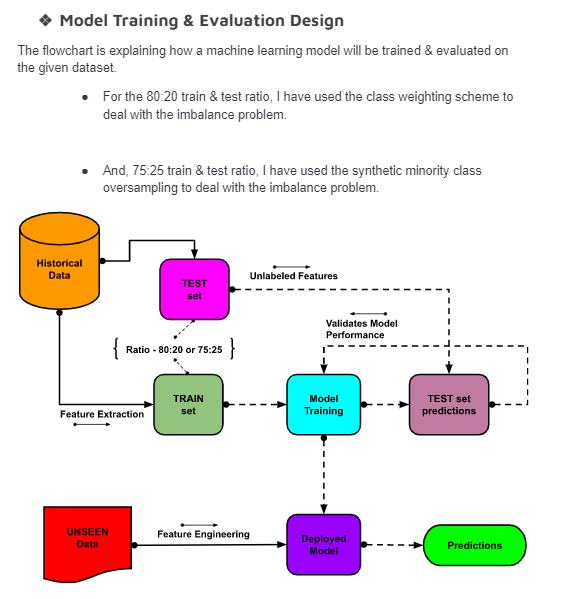

In [49]:
from IPython.display import Image
Image("train_and_Eva.png")

In [50]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, stratify=y, random_state=39)

In [51]:
# Checking shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4328, 299), (1082, 299), (4328,), (1082,))

In [52]:
# Checking count of tgt labels in y_train
y_train.value_counts()

0    3923
1     405
Name: PotentialFraud, dtype: int64

In [53]:
# Checking count of tgt labels in y_test
y_test.value_counts()

0    981
1    101
Name: PotentialFraud, dtype: int64

### Standardizing TRAIN & TEST sets
Bringing every feature into the same scale.

In [54]:
from sklearn.preprocessing import RobustScaler
# Standardize the data (train and test)
robust_scaler = RobustScaler()
robust_scaler.fit(X_train)
X_train_std = robust_scaler.transform(X_train)
X_test_std = robust_scaler.transform(X_test)

### Baseline Model Training
Using Class Weighting Scheme
1. Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [56]:
# Training the model with all features and hyper-parameterized values
log_reg_1 = LogisticRegression(C=0.0316228, penalty='l1',
                               fit_intercept=True, solver='liblinear', tol=0.0001, max_iter=500, 
                               class_weight='balanced',
                               verbose=0, 
                               intercept_scaling=1.0,
                               multi_class='auto',
                               random_state=49)

log_reg_1.fit(X_train_std, y_train)

LogisticRegression(C=0.0316228, class_weight='balanced', intercept_scaling=1.0,
                   max_iter=500, penalty='l1', random_state=49,
                   solver='liblinear')

In [59]:
def pred_prob(clf, data): 
    """
    Description :: This function is created for storing the predicted probabability using the trained model.
    
    Input :: It accepts below input parameters :
      - clf : Trained model classifier
      - data : Dataset for which we want to generate the predictions
    """
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    """
    Description :: This function is created for calculating the AUC score on train and test data. And, plotting the ROC curve.
    
    Input :: It accepts below input parameters :
      - train_fpr : Train False +ve rate
      - train_tpr : Train True +ve rate
      - test_fpr : Test False +ve rate
      - test_tpr : Test True +ve rate
    """
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    with plt.style.context('seaborn-poster'):
      plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc), color='blue')
      plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc), color='red')
      plt.legend()
      plt.xlabel("False Positive Rate(FPR)")
      plt.ylabel("True Positive Rate(TPR)")
      plt.title("Area Under Curve")
      plt.grid(b=True, which='major', color='lightgrey', linestyle='--')
      plt.minorticks_on()
      plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    """
    Description :: This function is created for finding the best threshold value.
    """
    t = threshold[np.argmax(tpr * (1-fpr))]
    return t

def predict_with_best_t(proba, threshold):
    """
    Description :: This function is created for generating the predictions based on the best threshold value.
    """
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    """
    Description :: This function is created for plotting the confusion matrix of TRAIN and TEST sets.
    """
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    with plt.style.context('seaborn'):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='viridis')
        ax[0].set_title('Train Dataset Confusion Matrix')
        ax[0].set_xlabel("Predicted Label")
        ax[0].set_ylabel("Actual Label")

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    with plt.style.context('seaborn'):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax[1], cmap='summer')
        ax[1].set_title('Test Dataset Confusion Matrix')
        ax[1].set_xlabel("Predicted Label")
        ax[1].set_ylabel("Actual Label")
    
    plt.show()
    
    return train_prediction, test_prediction
def validate_model(clf, x_train, x_test, y_train, y_test):
    """
    Description :: This function is created for performing the evaluation of the trained model.
    """
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    
    # calculate tpr, fpr using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("### Train AUC = {}".format(train_auc))
    test_auc = auc(test_fpr, test_tpr)
    print("### Test AUC = {}".format(test_auc))
    
    # plotting the ROC curve
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    # Best threshold value
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    # Plotting the confusion matrices
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
    
    # Generating the F1-scores
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, train_f1_score, test_f1_score, best_t

### Train AUC = 0.9489399332206708
### Test AUC = 0.9267165248634954


C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\1852561258.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='lightgrey', linestyle='--')


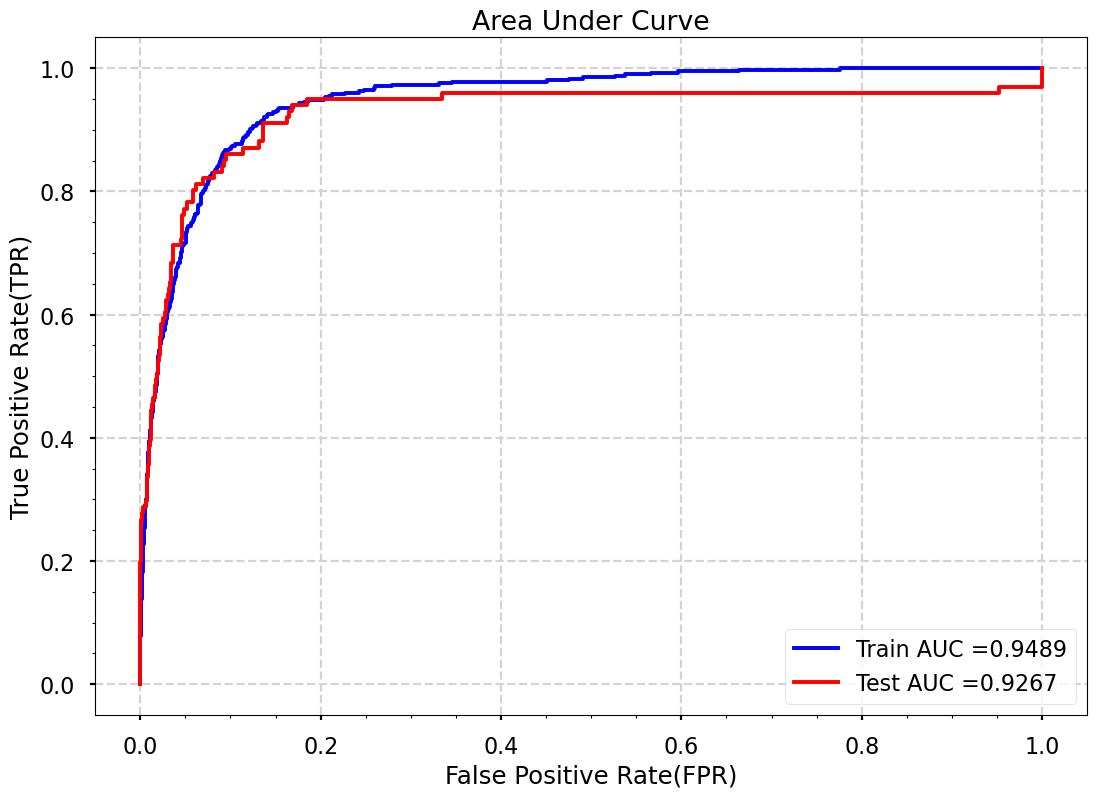

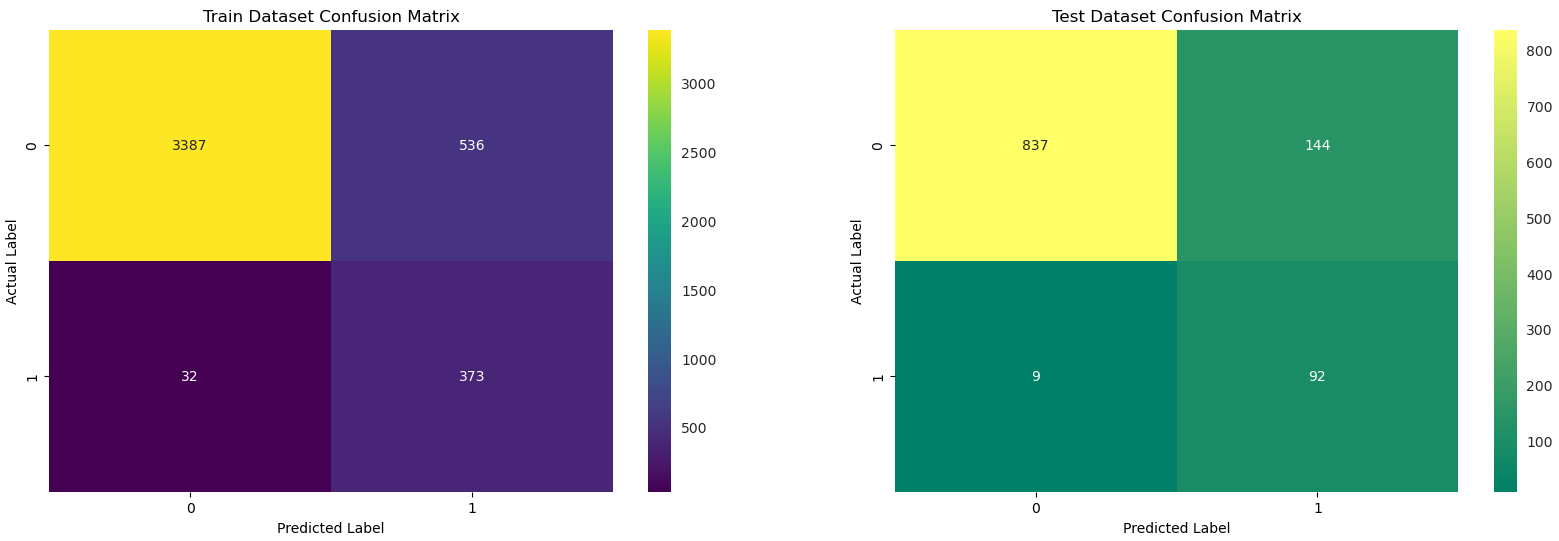



### Best Threshold = 0.3548
### Model AUC is : 0.9267
### Model Train F1 Score is : 0.5677
### Model Test F1 Score is : 0.5460


In [60]:
#  Validate Logistic Regression model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(log_reg_1, X_train_std, X_test_std, y_train, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [61]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': log_reg_1.coef_[0]})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.514217
1,Admitted_Duration,0.529917
2,PRV_Tot_Admit_DCodes,-0.050210
3,PRV_Tot_DGrpCodes,-0.069864
4,PRV_Tot_Unq_DOB_Years,0.065862


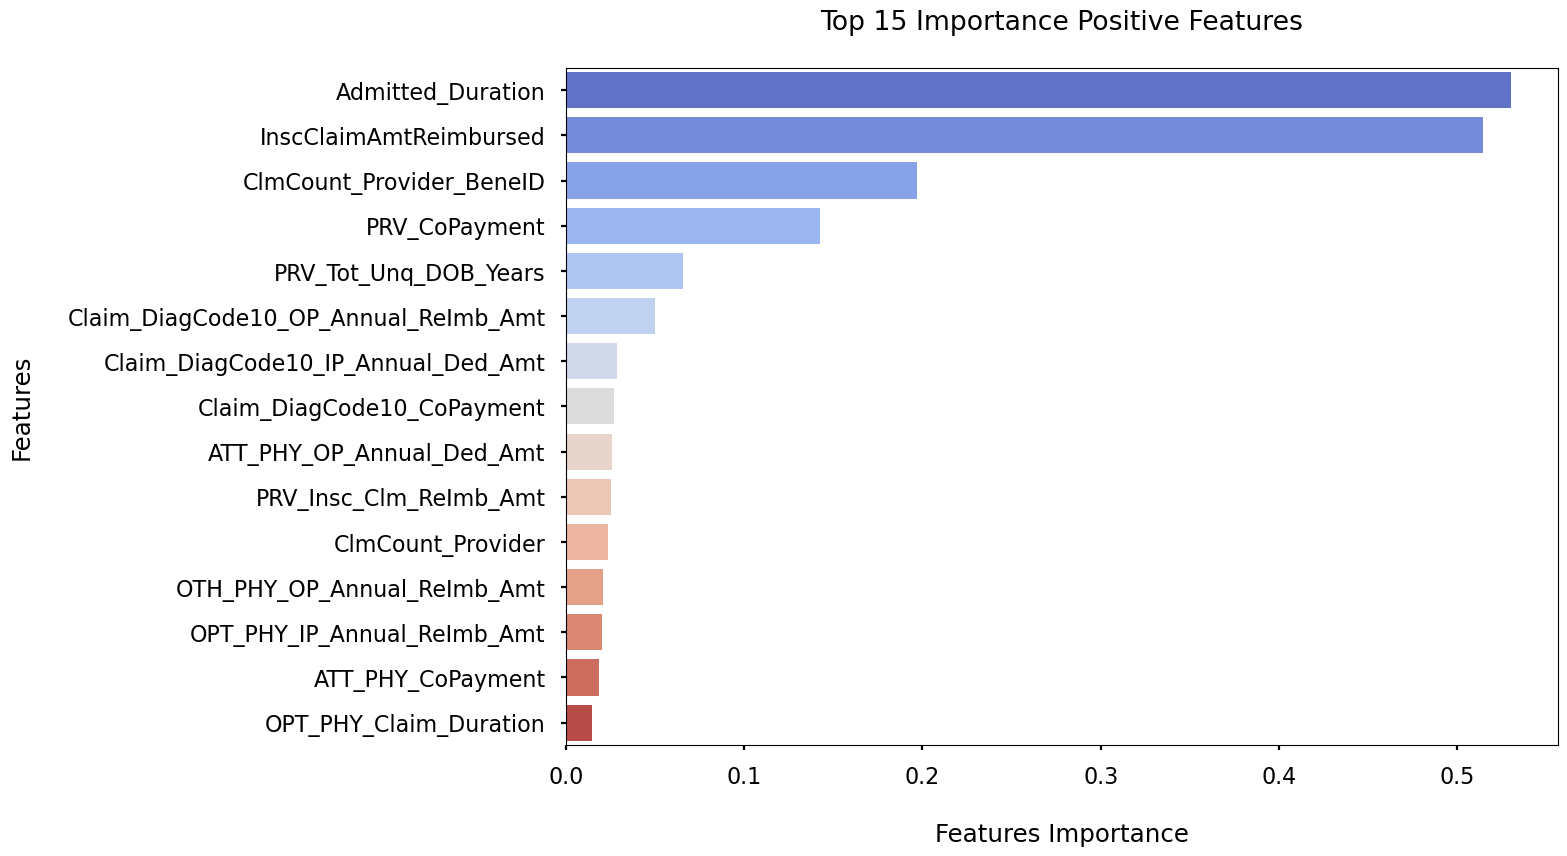

In [63]:
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]
top_15_neg_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Features'].iloc[0:15]
top_15_neg_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Importance_Model_1'].iloc[0:15]
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance")
    plt.ylabel("Features\n")
    plt.title("Top 15 Importance Positive Features\n")

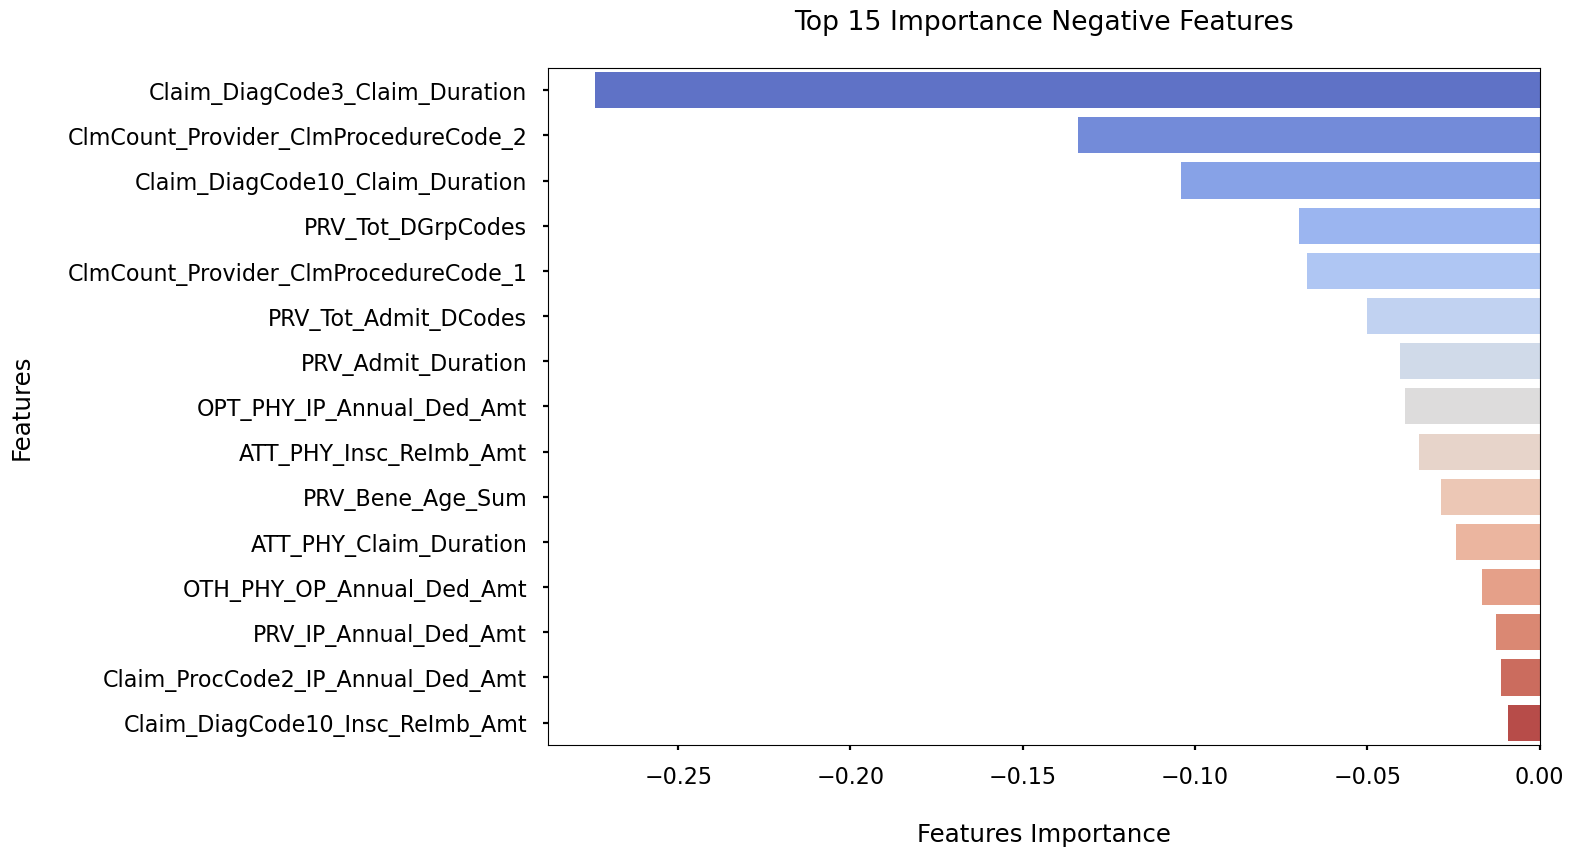

In [64]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_neg_feats, x=top_15_neg_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance")
    plt.ylabel("Features\n")
    plt.title("Top 15 Importance Negative Features\n")

### 2. Decision Tree
from sklearn.tree import DecisionTreeClassifier

In [65]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
# Training the model with all features and hyper-parameterized values
dec_tree_2 = DecisionTreeClassifier(criterion='gini',
                                   max_depth= 6,
                                   max_features='log2',
                                   min_samples_leaf=150,
                                   min_samples_split=150,
                                   class_weight='balanced',
                                   random_state=49,
                                   splitter='best',
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

dec_tree_2.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       max_features='log2', min_samples_leaf=150,
                       min_samples_split=150, random_state=49)

### Train AUC = 0.9264832595361951
### Test AUC = 0.9259948930672883


C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\1852561258.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='lightgrey', linestyle='--')


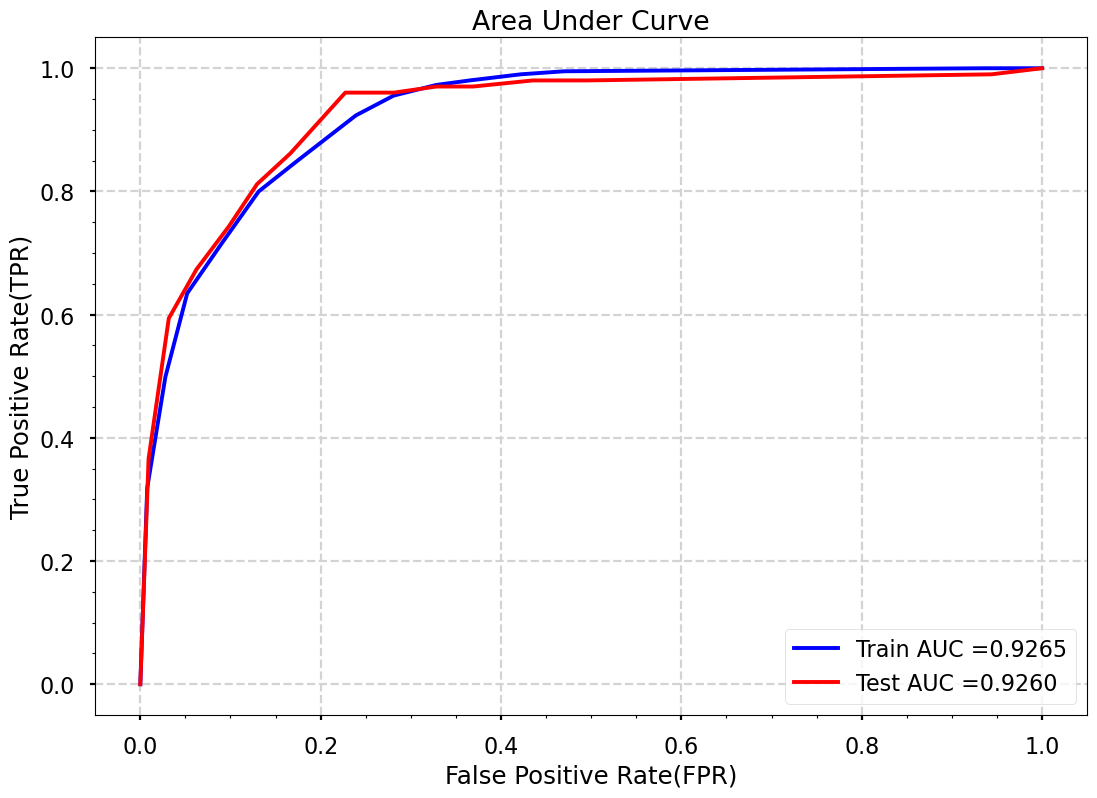

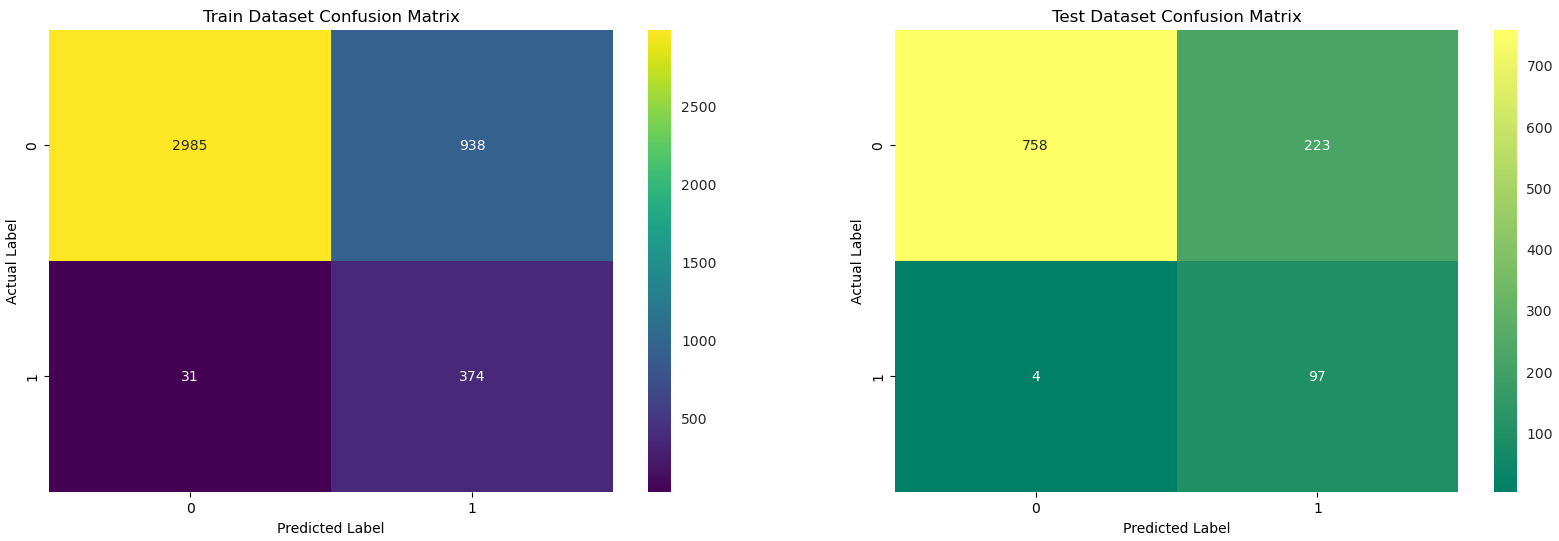



### Best Threshold = 0.5316
### Model AUC is : 0.9260
### Model Train F1 Score is : 0.4356
### Model Test F1 Score is : 0.4608


In [67]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(dec_tree_2, X_train_std, X_test_std, y_train, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [68]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': dec_tree_2.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()


,Features,Importance_Model_1
0,DeductibleAmtPaid,0.040583
1,OPT_PHY_Admit_Duration,0.003299
2,OTH_PHY_Claim_Duration,0.000785
3,Claim_Admit_Diag_Code_IP_Annual_ReImb_Amt,0.700819
4,Claim_Admit_Diag_Code_IP_Annual_Ded_Amt,0.002466


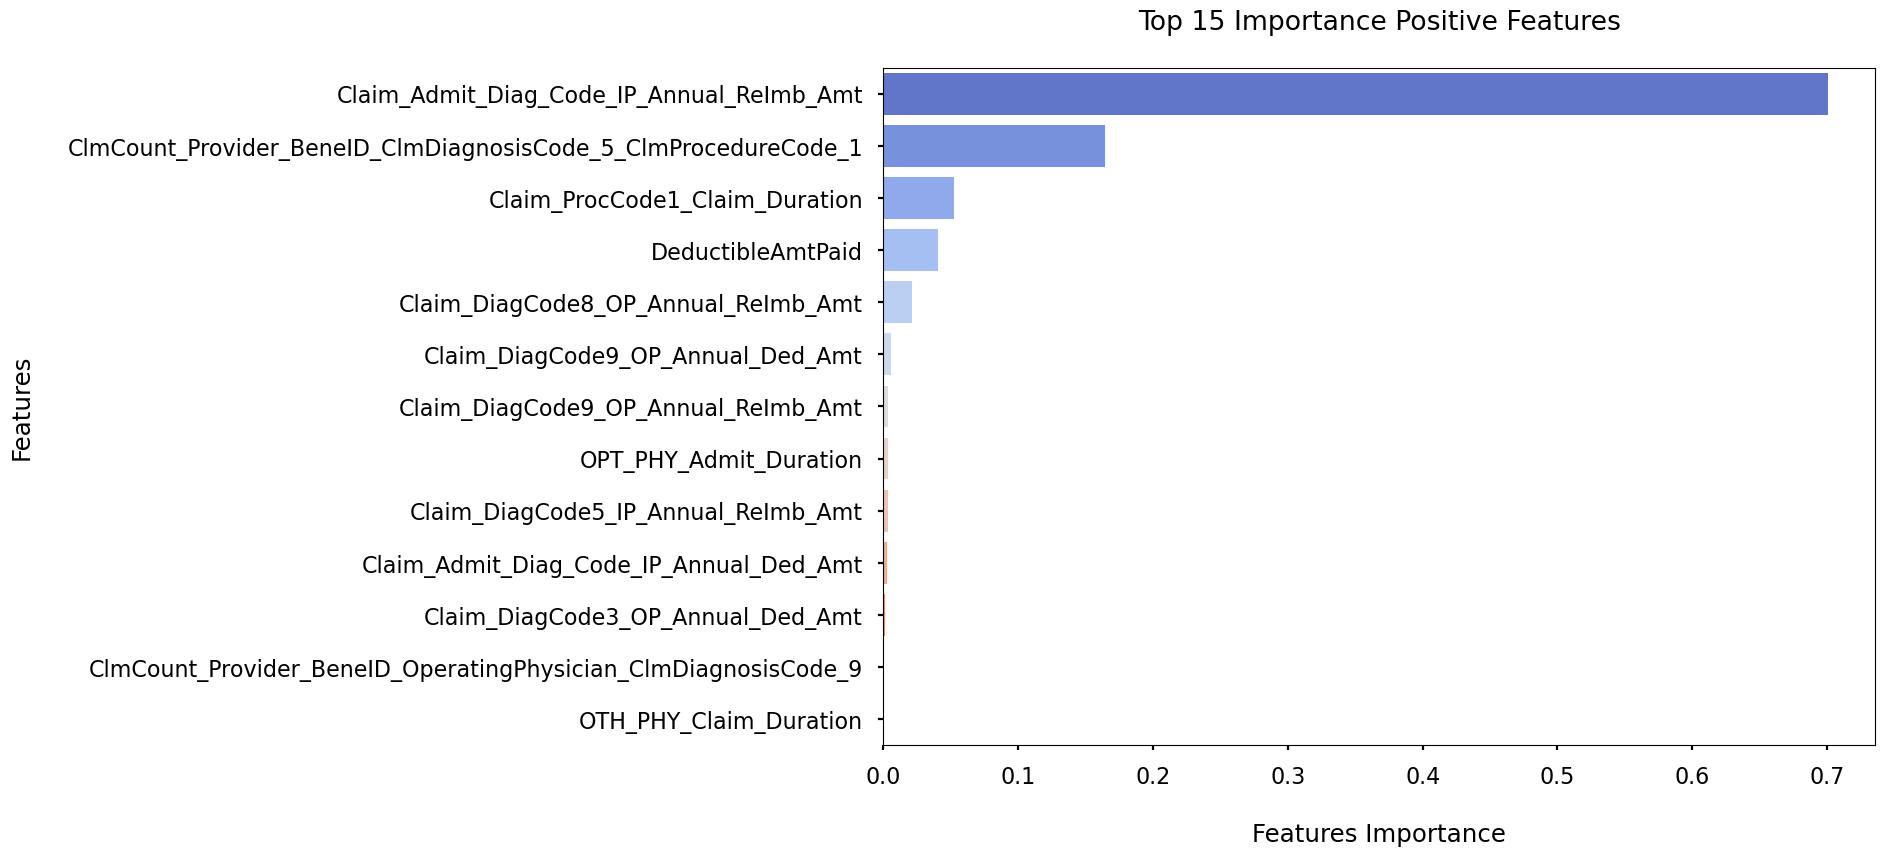

In [70]:
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance")
    plt.ylabel("Features\n")
    plt.title("Top 15 Importance Positive Features\n")

### 3. Random Forest Classifier

In [71]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
# Training the model with all features and hyper-parameterized values
rfc_3 = RandomForestClassifier(n_estimators=30,criterion='gini',
                                   max_depth= 4,
                                   max_features='auto',
                                   min_samples_leaf=50,
                                   min_samples_split=50,
                                   class_weight='balanced',
                                   random_state=49,
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

rfc_3.fit(X_train_std, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=50, min_samples_split=50,
                       n_estimators=30, random_state=49)

### Train AUC = 0.9517215660728278
### Test AUC = 0.9569796429184203


C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\1852561258.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='lightgrey', linestyle='--')


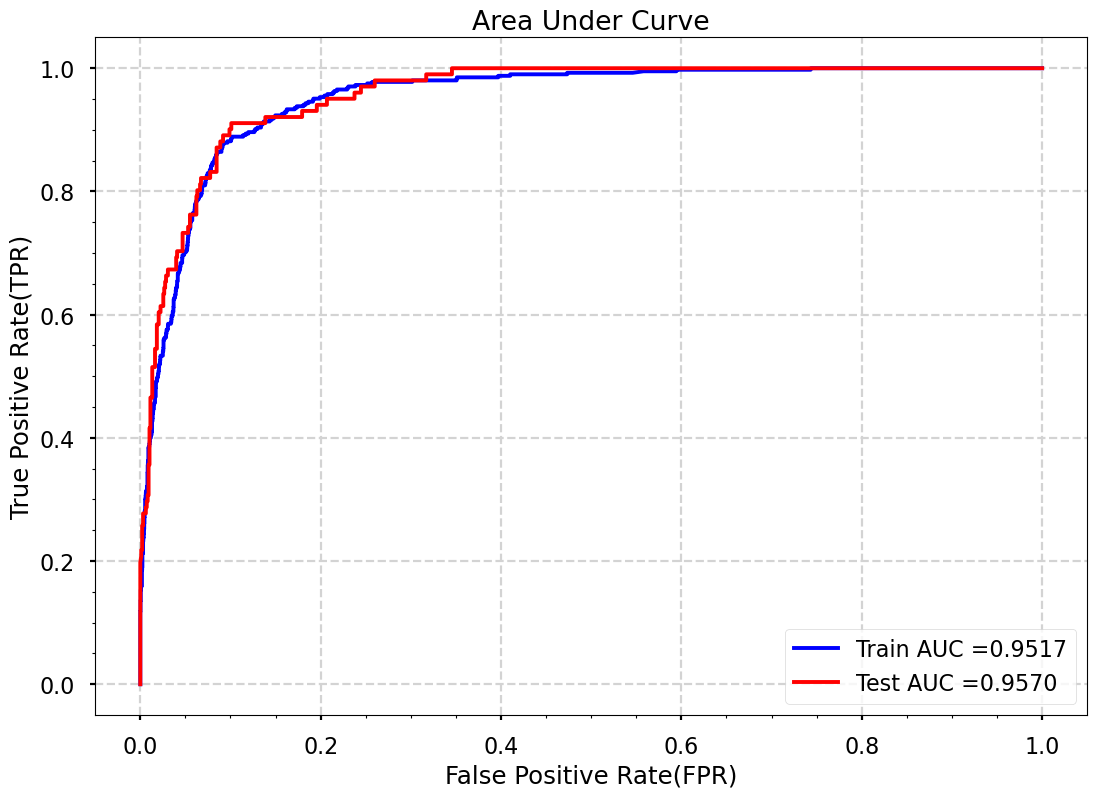

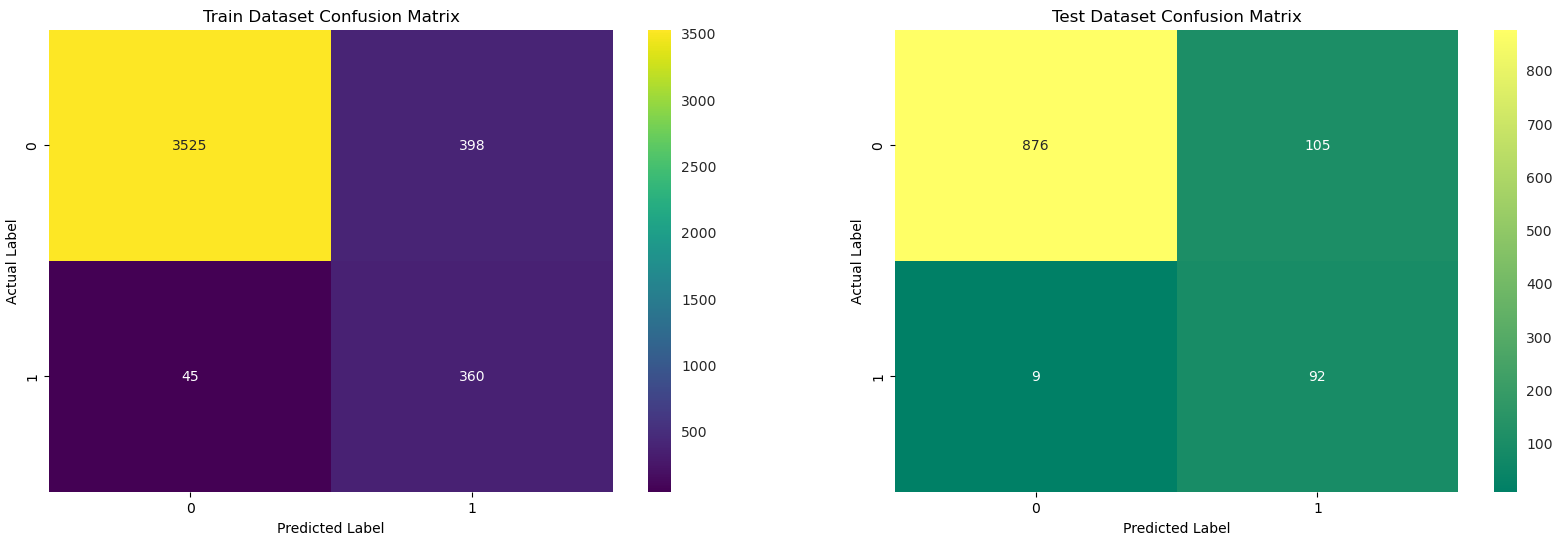



### Best Threshold = 0.5579
### Model AUC is : 0.9570
### Model Train F1 Score is : 0.6191
### Model Test F1 Score is : 0.6174


In [73]:
RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=50, min_samples_split=50,
                       n_estimators=30, random_state=49)
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(rfc_3, X_train_std, X_test_std, y_train, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [74]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': rfc_3.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.011885
1,DeductibleAmtPaid,0.026464
2,RenalDiseaseIndicator,0.000185
3,ChronicCond_Cancer,0.000288
4,ChronicCond_ObstrPulmonary,0.000863


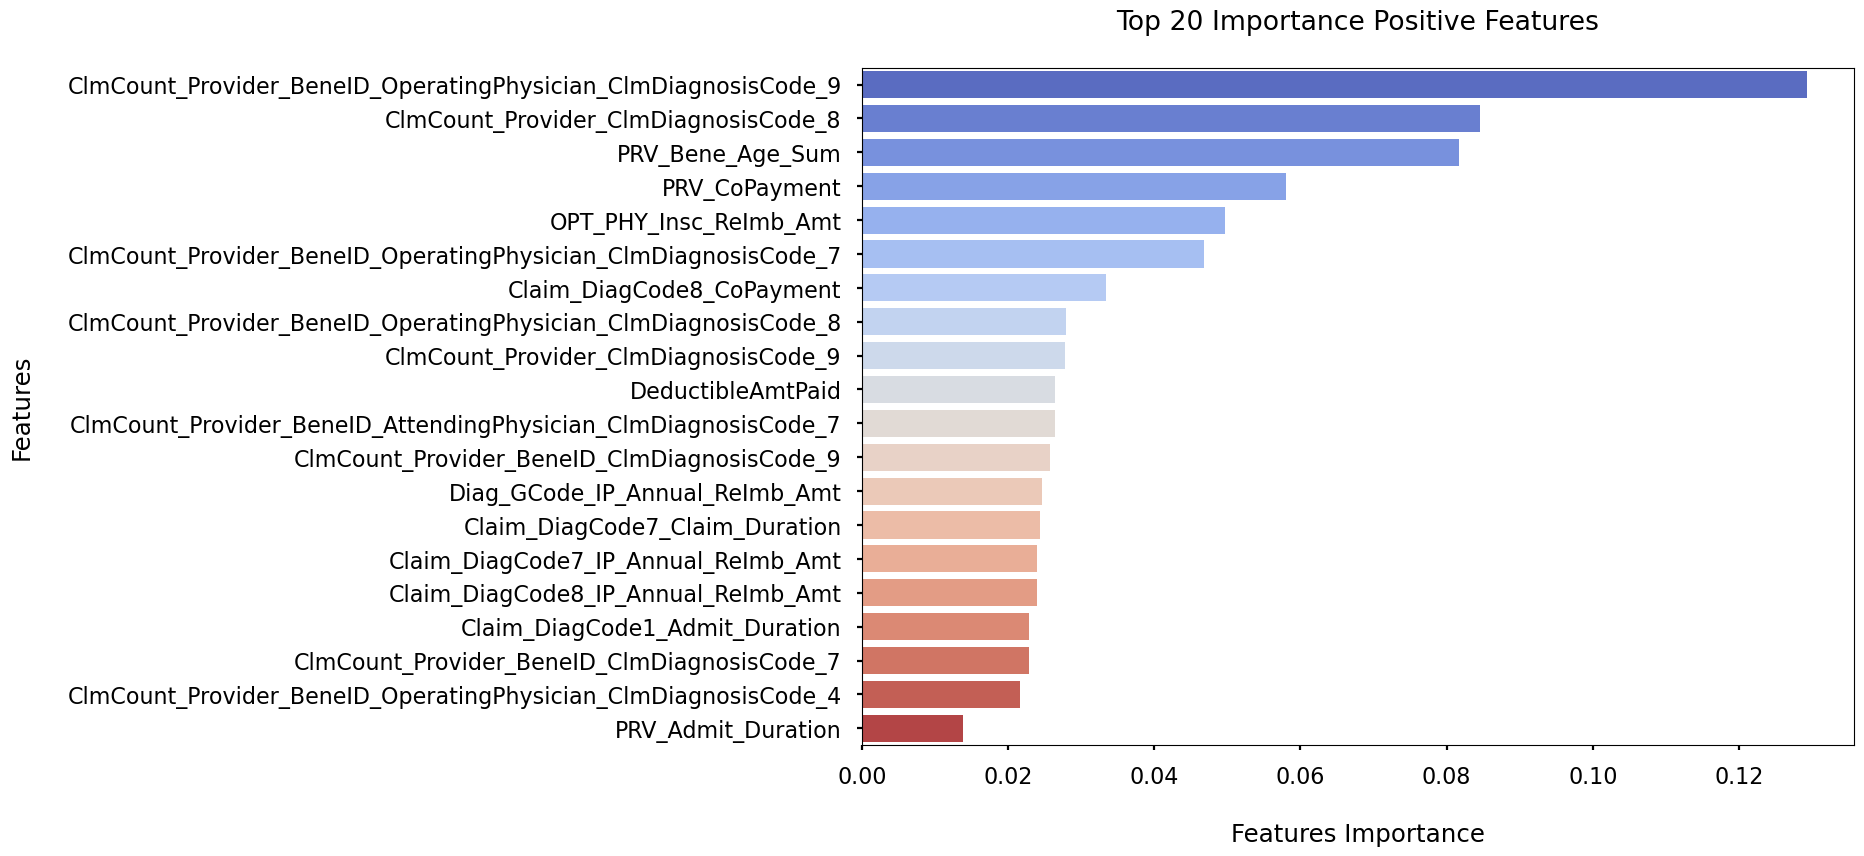

In [76]:
top_20_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:20]
top_20_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:20]
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_20_pos_feats, x=top_20_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance")
    plt.ylabel("Features\n")
    plt.title("Top 20 Importance Positive Features\n")

## Using Minority Synthetic Oversampling
Train Test Split :: Creating TRAIN and VALIDATION sets.
Reasoning :: These sets will be used for measurng the performance of ML Models.

In [77]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25, stratify=y, random_state=39)

In [78]:
# Checking shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# ((4057, 299), (1353, 299), (4057,), (1353,))
# Checking count of tgt labels in y_train
y_train.value_counts()

0    3678
1     379
Name: PotentialFraud, dtype: int64

Standardizing the TRAIN & TEST sets :: Bringing every feature into the same scale.

In [79]:
from sklearn.preprocessing import RobustScaler
# Standardize the data (train and test)
robust_scaler = RobustScaler()
robust_scaler.fit(X_train)
X_train_std = robust_scaler.transform(X_train)
X_test_std = robust_scaler.transform(X_test)
from collections import Counter
# BEFORE Oversampling :: Checking the percentage share of fraud and non-fraud records in the TRAIN set
counter = Counter(y_train)
counter

Counter({0: 3678, 1: 379})

In [81]:
fraud_percentage = (counter[1]*100 / (counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100 / (counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

# Performing minority oversampling
# from imblearn.over_sampling import ADASYN

Fraud Percentage = 9.34% and Non-Fraud Percentage = 90.66%


In [83]:
# Performing minority oversampling
from imblearn.over_sampling import ADASYN
oversample = ADASYN(sampling_strategy=0.35, n_neighbors=12)
X_train_ovsamp, y_train_ovsamp = oversample.fit_resample(X_train_std, y_train)

X_train_ovsamp.shape, y_train_ovsamp.shape
# ((4983, 299), (4983,))
counter = Counter(y_train_ovsamp)
counter

Counter({0: 3678, 1: 1302})

In [84]:
fraud_percentage = (counter[1]*100 / (counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100 / (counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 26.14% and Non-Fraud Percentage = 73.86%


### 4. Logistic Regression

In [85]:
# Training the model with all features and hyper-parameterized values
log_reg_4 = LogisticRegression(C=0.0316228, penalty='l1',
                               fit_intercept=True, 
                               solver='liblinear', 
                               tol=0.0001, 
                               max_iter=500, 
                               verbose=0, 
                               intercept_scaling=1.0,
                               multi_class='auto',
                               random_state=49)

log_reg_4.fit(X_train_ovsamp, y_train_ovsamp)

LogisticRegression(C=0.0316228, intercept_scaling=1.0, max_iter=500,
                   penalty='l1', random_state=49, solver='liblinear')

### Train AUC = 0.9409481293262801
### Test AUC = 0.9135399673735726


C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\1852561258.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='lightgrey', linestyle='--')


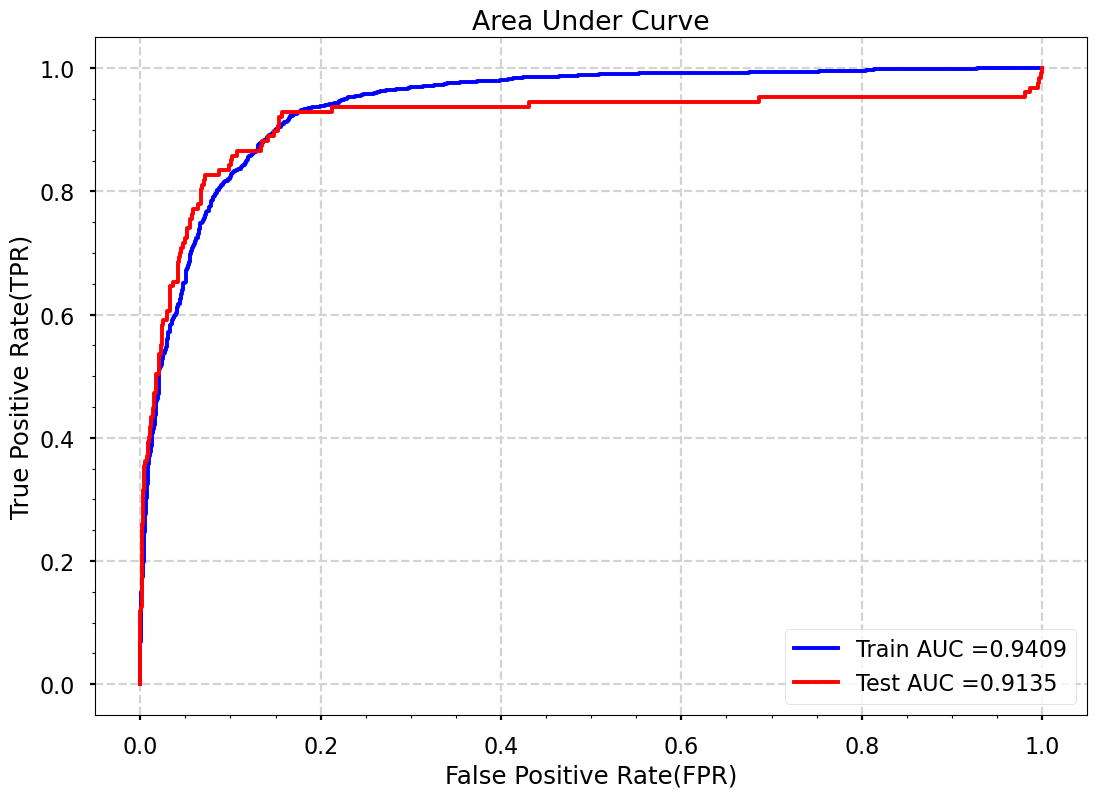

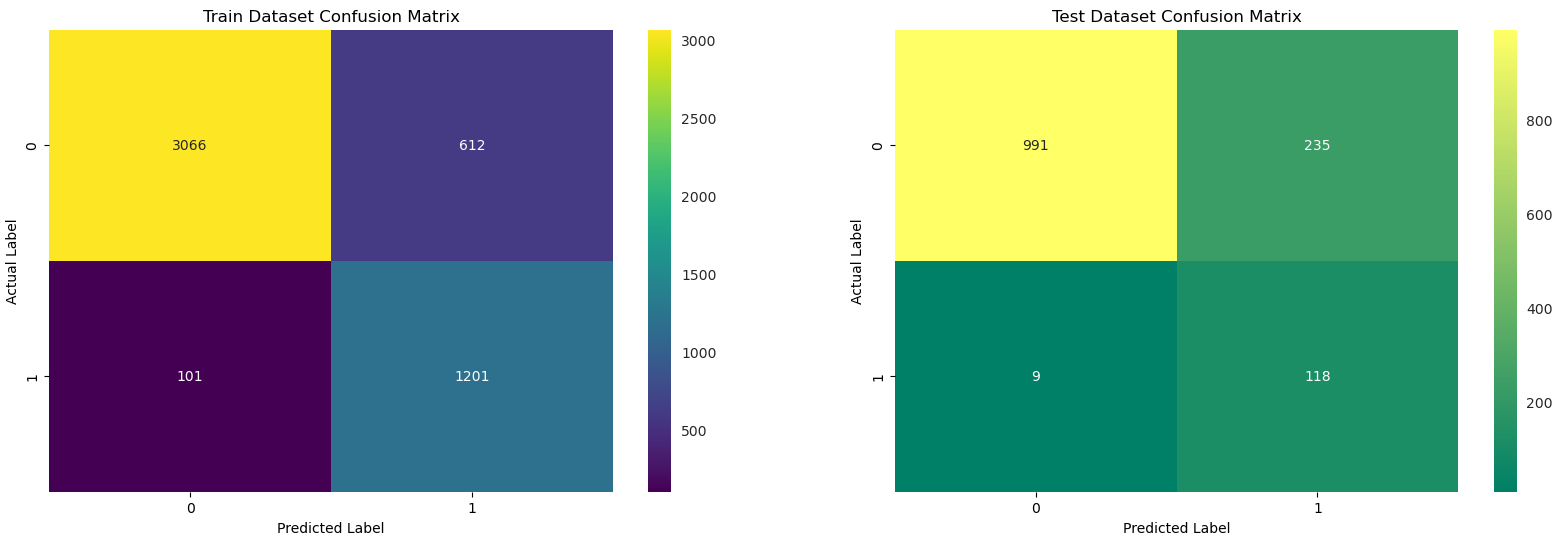



### Best Threshold = 0.1597
### Model AUC is : 0.9135
### Model Train F1 Score is : 0.7711
### Model Test F1 Score is : 0.4917


In [86]:
# Validate Logistic Regression model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(log_reg_4, X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [87]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': log_reg_4.coef_[0]})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.498240
1,ChronicCond_Alzheimer,-0.005998
2,Admitted_Duration,0.462308
3,PRV_Tot_Admit_DCodes,-0.070107
4,PRV_Tot_DGrpCodes,-0.031552


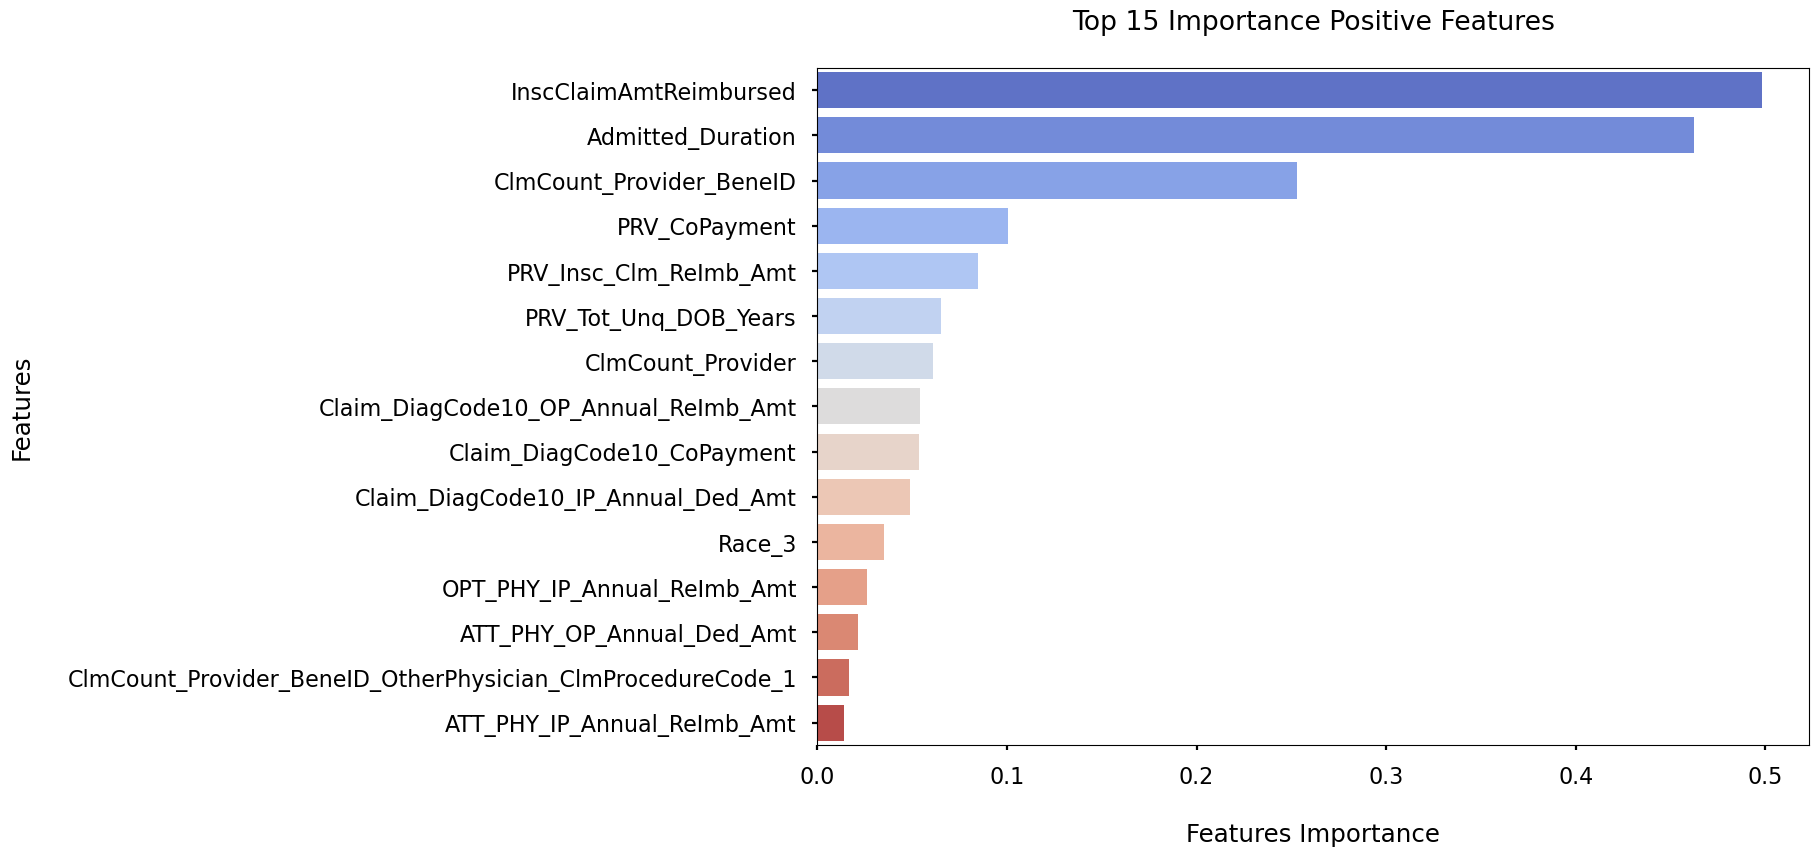

In [88]:
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]
top_15_neg_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Features'].iloc[0:15]
top_15_neg_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=True)['Importance_Model_1'].iloc[0:15]
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance")
    plt.ylabel("Features\n")
    plt.title("Top 15 Importance Positive Features\n")

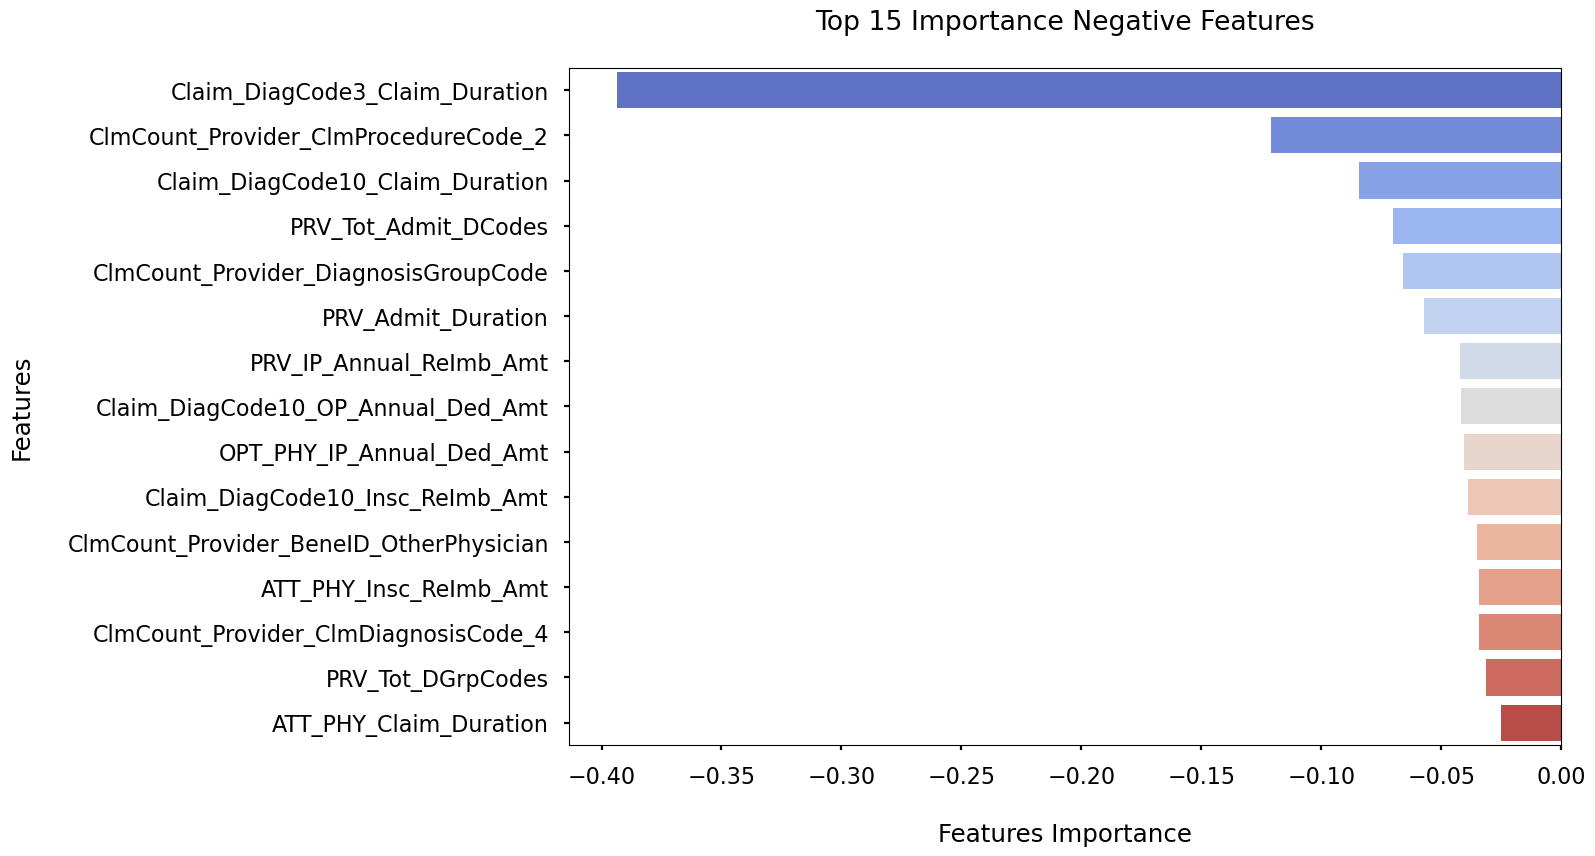

In [89]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_neg_feats, x=top_15_neg_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance")
    plt.ylabel("Features\n")
    plt.title("Top 15 Importance Negative Features\n")

### 5. Decision Tree

In [90]:
from sklearn.tree import DecisionTreeClassifier
# Training the model with all features and hyper-parameterized values
dec_tree_5 = DecisionTreeClassifier(criterion='gini',
                                   max_depth= 6,
                                   max_features='log2',
                                   min_samples_leaf=150,
                                   min_samples_split=150,
                                   random_state=49,
                                   splitter='best',
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

dec_tree_5.fit(X_train_ovsamp, y_train_ovsamp)

DecisionTreeClassifier(max_depth=6, max_features='log2', min_samples_leaf=150,
                       min_samples_split=150, random_state=49)

### Train AUC = 0.9340654441362224
### Test AUC = 0.9368151982633492


C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\1852561258.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='lightgrey', linestyle='--')


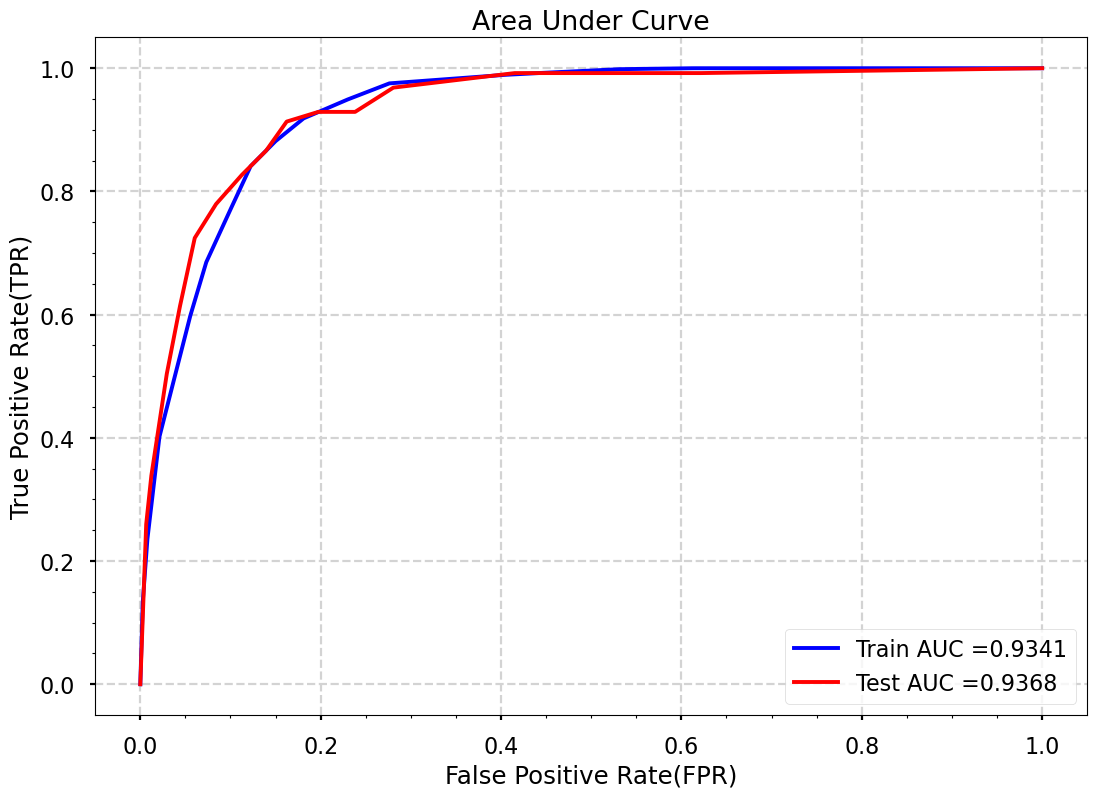

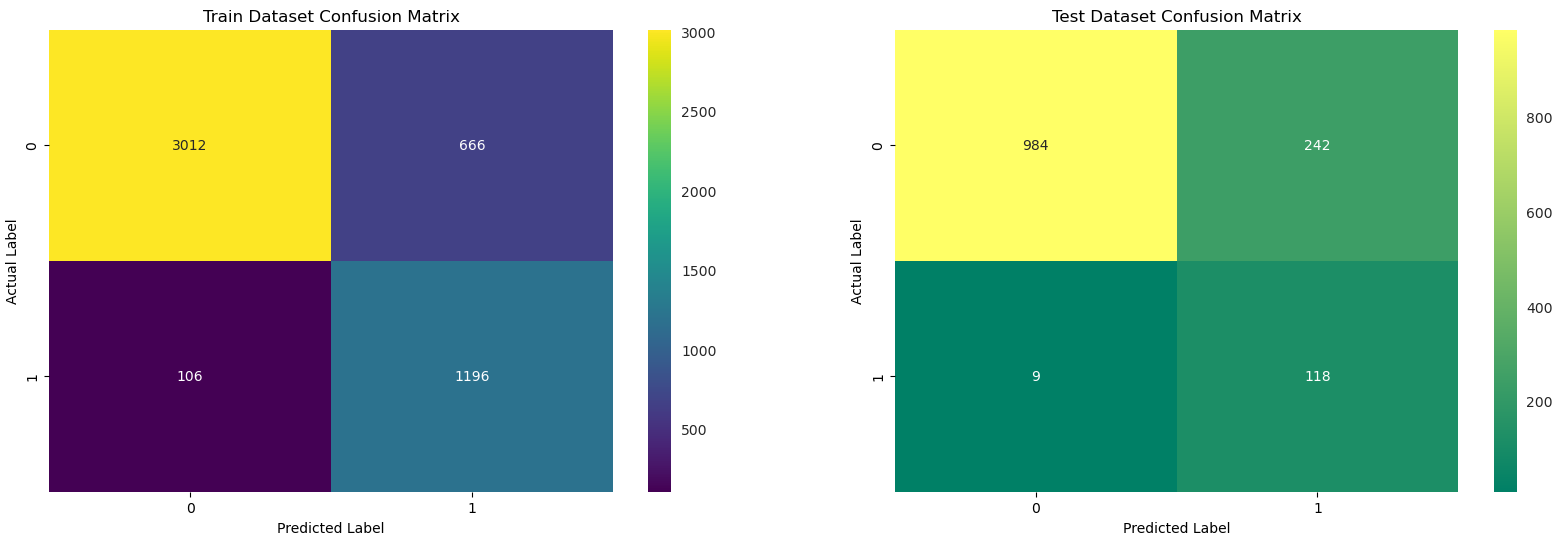



### Best Threshold = 0.2963
### Model AUC is : 0.9368
### Model Train F1 Score is : 0.7560
### Model Test F1 Score is : 0.4846


In [91]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(dec_tree_5, X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

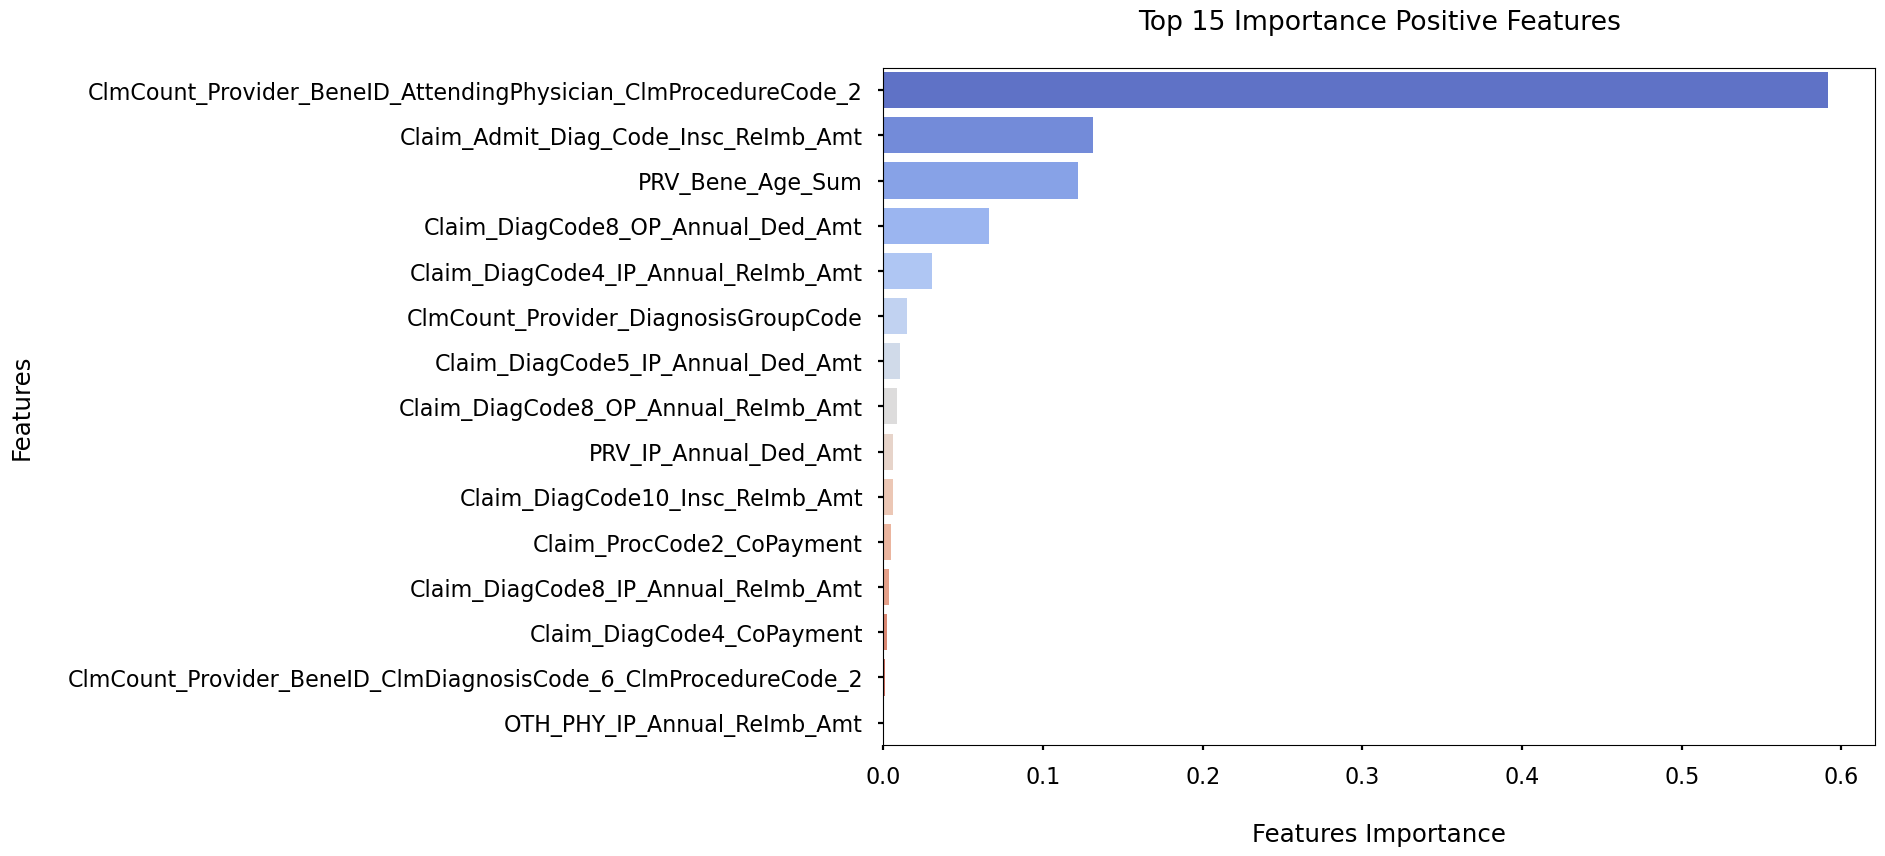

In [92]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': dec_tree_5.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()
top_15_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:15]
top_15_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:15]
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_15_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance")
    plt.ylabel("Features\n")
    plt.title("Top 15 Importance Positive Features\n")

### 6. Random Forest Classifier

In [93]:
from sklearn.ensemble import RandomForestClassifier
# Training the model with all features and hyper-parameterized values
rfc_6 = RandomForestClassifier(n_estimators=30,criterion='gini',
                                   max_depth= 4,
                                   max_features='auto',
                                   min_samples_leaf=50,
                                   min_samples_split=50,
                                   random_state=49,
                                   min_weight_fraction_leaf=0.0,
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   ccp_alpha=0.0,)

rfc_6.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=50, min_samples_split=50,
                       n_estimators=30, random_state=49)

### Train AUC = 0.9339837945387068
### Test AUC = 0.9531380457540688


C:\Users\Sheriff\AppData\Local\Temp\ipykernel_19388\1852561258.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='lightgrey', linestyle='--')


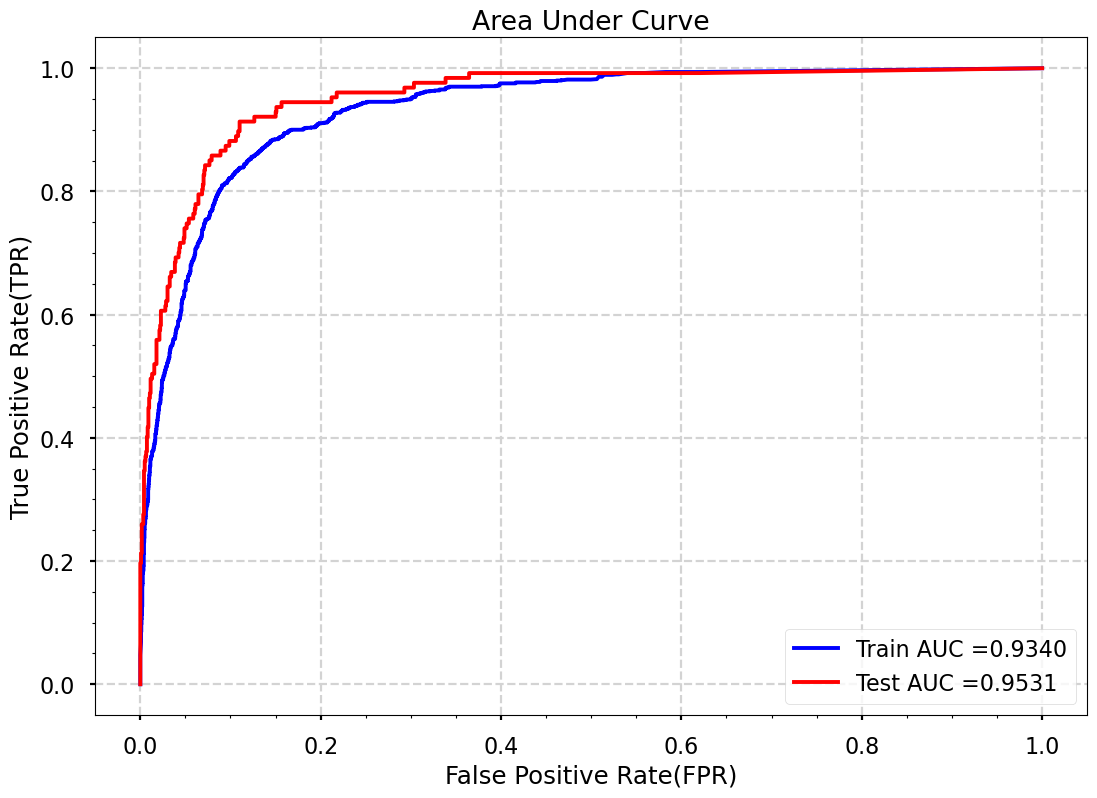

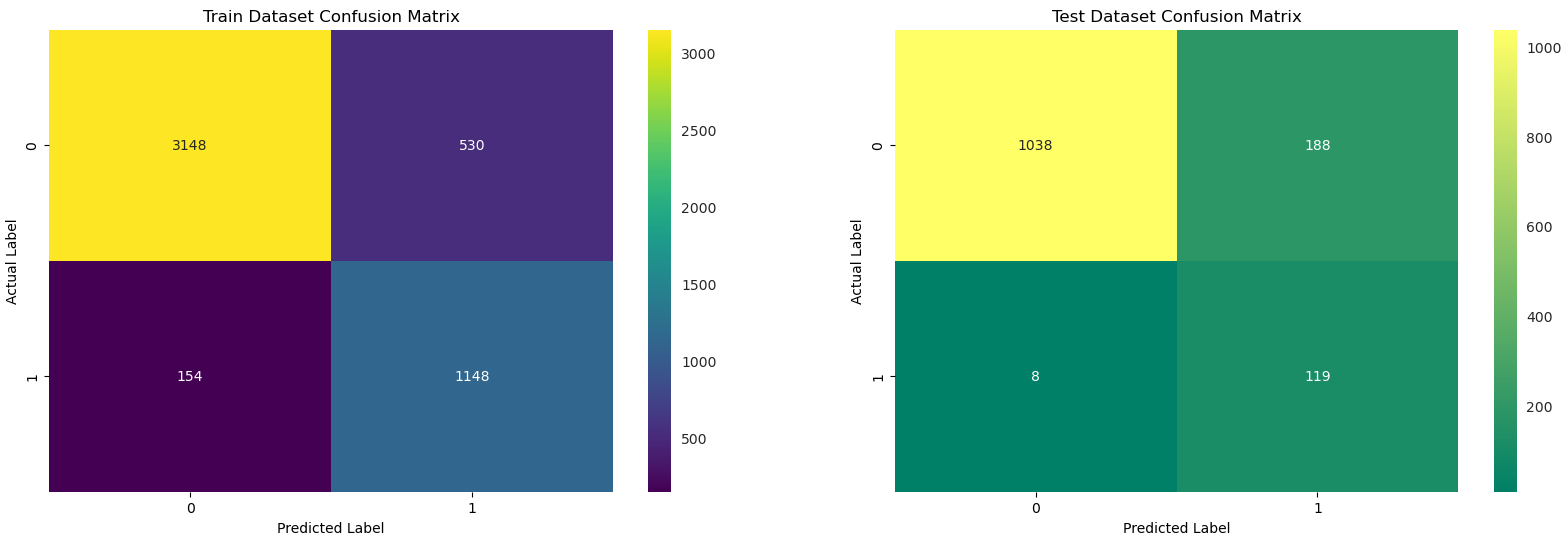



### Best Threshold = 0.1035
### Model AUC is : 0.9531
### Model Train F1 Score is : 0.7705
### Model Test F1 Score is : 0.5484


In [94]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(rfc_6, X_train_ovsamp, X_test_std, y_train_ovsamp, y_test)

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

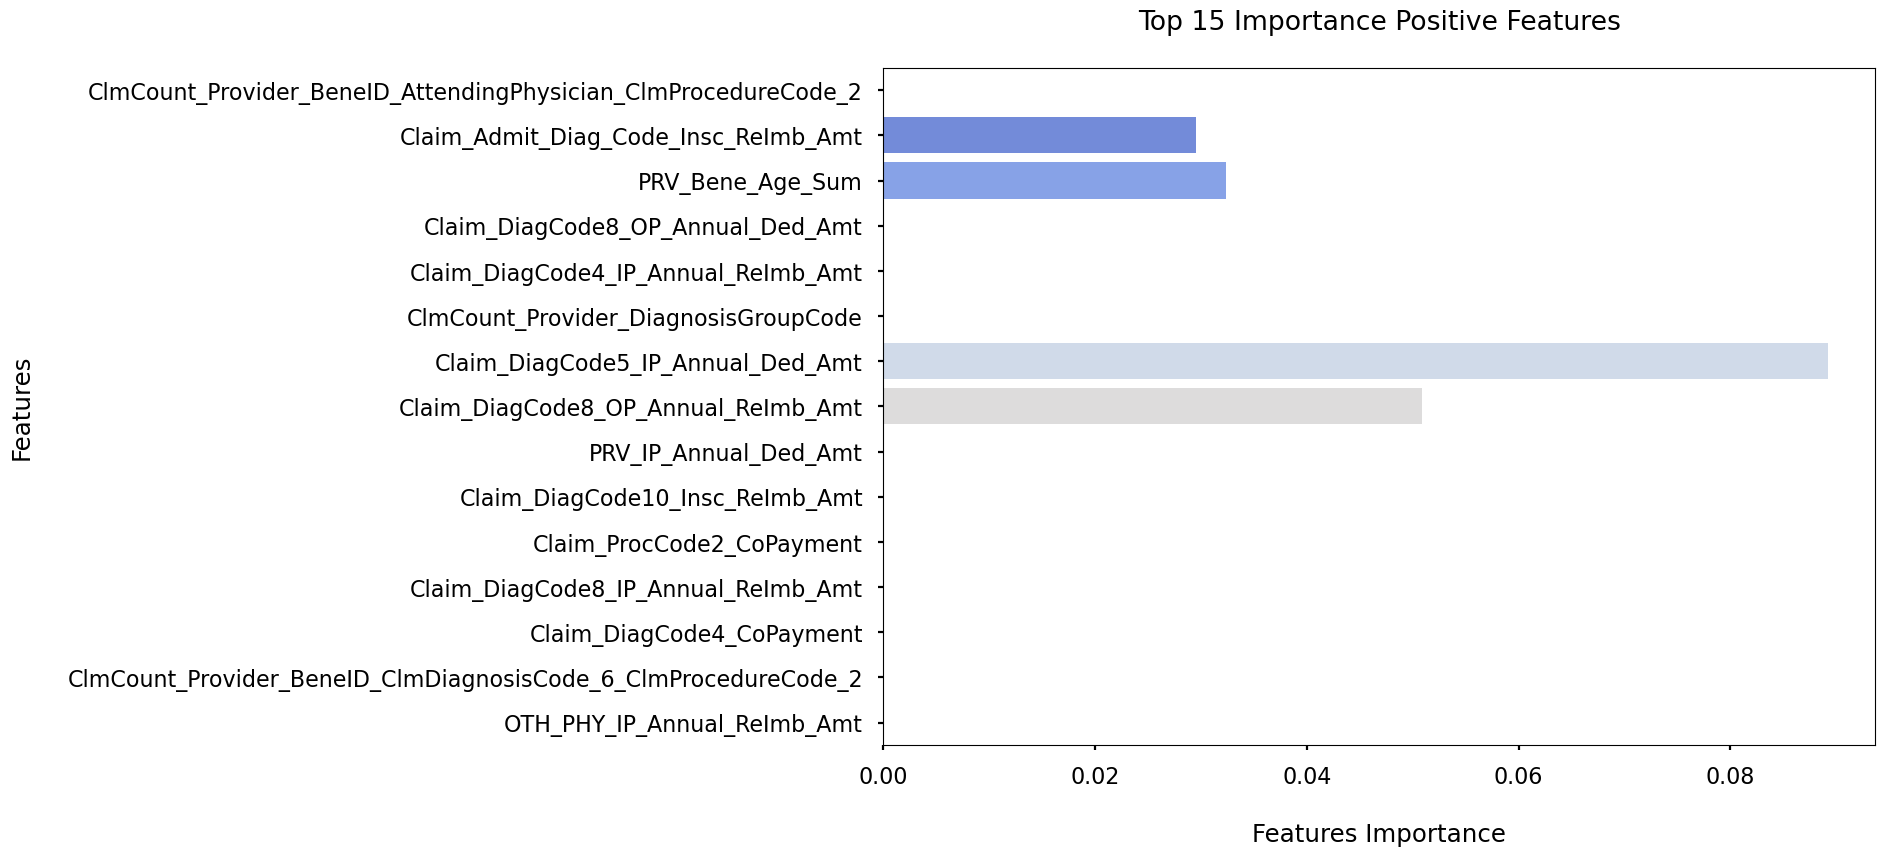

In [95]:
feats_imps = pd.DataFrame({'Features': X_train.columns, 'Importance_Model_1': rfc_6.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)
feats_imps.head()
top_20_pos_feats = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:20]
top_20_pos_feats_scores = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:20]
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_15_pos_feats, x=top_20_pos_feats_scores, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance")
    plt.ylabel("Features\n")
    plt.title("Top 15 Importance Positive Features\n")

### Models - SET 1 - RESULTS
Best performing model highlighted in light yellow in the below table.

### Models - SET 1 - OBSERVATIONS
Adding Aggregated features at below mentioned levels certainly helped in achieving the good performance scores.

Provider

Beneficiary

Attending Physician

Operating Physician

Other Physician and etc..

Adding below mentioned Aggregated features in order to capture the interactions b/w the different parties involved in the CLAIM process certainly helped in achieving the good performance scores.

PROVIDER <--> BENE <--> PHYSICIANS

PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> PROCEDURE CODES

PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> PROCEDURE CODES

PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> PROCEDURE CODES

PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> DIAGNOSIS CODES

PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> DIAGNOSIS CODES

PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> DIAGNOSIS CODES

PROVIDER <--> BENE <--> DIAGNOSIS CODES <--> PROCEDURE CODES and etc..

Doing the synthetic oversampling of the minority class doesn't provide gain in the model's performance whehreas we can see a slight drop in the performace.

### Feature Engineering set2

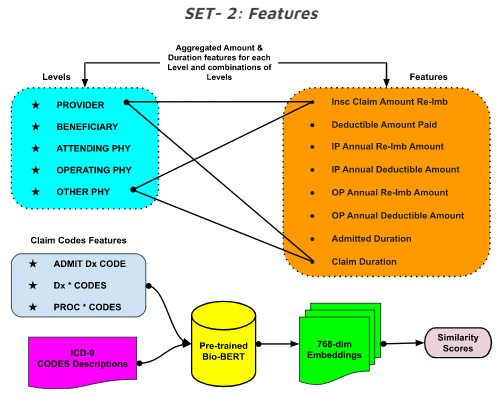

In [97]:
# Feature Engg - SET 2
from IPython.display import Image
Image("set2.png")